In [448]:
import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import GRNCellPop, SciplexGRNCellPop
from flecs.trajectory import simulate_deterministic_trajectory
import anndata as ad
import seaborn as sns
import pandas as pd
from scipy.spatial import distance_matrix
from flecs.sc.dataset import SciplexDataset
import scipy
import pandas as pd
import matplotlib.patches as mpatches
import ot
import matplotlib as mpl

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (16,8)

## Load data

In [40]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(),
                                  "datasets", "Sciplex3", "processed", 
                                  "SrivatsanTrapnell2020_sciplex3_with_all_paths.h5ad")
                     )

In [41]:
sparsity_rand_edges = 0.1
adj_mat = adata.varp["grn_adj_mat"]

adj_mat = adj_mat + np.random.choice([0, 1], size=adj_mat.shape, p=[1.-sparsity_rand_edges, sparsity_rand_edges])

print("edge density", adj_mat.sum() / (4000*4000))
adata.varp["grn_adj_mat"] = adj_mat

edge density 0.1077528125


In [42]:
train_dataset_pert_paths = np.load(os.path.join(get_project_root(), "figure5", "train_dataset_pert_paths.npy"), allow_pickle=True)
out_sample_indices = np.load(os.path.join(get_project_root(), "figure5", "sciplex_out_sample_indices.npy"))

In [43]:
obs_cells = list(adata.obs[adata.obs['perturbation'] == "control"].index.astype("int"))

In [44]:
obs_adata = adata[obs_cells]

In [45]:
train_len = 30
valid_len = 14

# Retrieve fingerprints
ChEMBL_to_morgan_fp_dict = adata.uns["ChEMBL_to_morgan_fp_dict"]

# Build dictionary mapping names to chembl-IDs
indices_with_id = ~adata.obs["chembl-ID"].isna() & adata.obs["chembl-ID"].apply(lambda x: x in ChEMBL_to_morgan_fp_dict)
perts_and_chembl = adata[indices_with_id].obs[['perturbation', 'chembl-ID']].copy()
perts_and_chembl.drop_duplicates(inplace=True)
pert_to_chembl_dict = perts_and_chembl.set_index("perturbation").to_dict()['chembl-ID']

# Retrieve perts for which paths are available
avail_paths = [k for k in list(adata.uns.keys()) if k.endswith("shortest_paths")]
avail_pert_with_path = [p[:-15] for p in avail_paths]

# Build dictionary mapping names to fingerprints
usable_perts = list(set(avail_pert_with_path).intersection(list(pert_to_chembl_dict.keys())))
usable_perts.sort()
usable_perts_to_fp_dict = {p: ChEMBL_to_morgan_fp_dict[pert_to_chembl_dict[p]] for p in usable_perts}

train_perts, valid_perts = torch.utils.data.random_split(
    usable_perts, [train_len, valid_len], generator=torch.Generator().manual_seed(0)
)
train_perts, valid_perts = list(train_perts), list(valid_perts)

print("train_perts", train_perts)

train_perts_with_fp_dict = {k: v for k, v in usable_perts_to_fp_dict.items() if k in train_perts}
valid_perts_with_fp_dict = {k: v for k, v in usable_perts_to_fp_dict.items() if k in valid_perts}

train_perts ['Roxadustat (FG-4592)', 'Enzastaurin (LY317615)', 'Thiotepa', 'Cerdulatinib (PRT062070, PRT2070)', 'Belinostat (PXD101)', 'Tacedinaline (CI994)', 'Cediranib (AZD2171)', 'SRT2104 (GSK2245840)', 'CYC116', 'Tucidinostat (Chidamide)', 'ZM 447439', 'AMG-900', 'Filgotinib (GLPG0634)', 'Barasertib (AZD1152-HQPA)', 'CUDC-101', 'Momelotinib (CYT387)', 'Hesperadin', 'Obatoclax Mesylate (GX15-070)', 'Raltitrexed', 'PHA-680632', 'Abexinostat (PCI-24781)', 'Entinostat (MS-275)', 'Trichostatin A (TSA)', 'Motesanib Diphosphate (AMG-706)', 'Panobinostat (LBH589)', 'Fluorouracil (5-Fluoracil, 5-FU)', 'Ruxolitinib (INCB018424)', 'Alisertib (MLN8237)', 'MK-5108 (VX-689)', 'Pirarubicin']


In [46]:
train_dataset = SciplexDataset(adata, train_perts_with_fp_dict)
valid_dataset = SciplexDataset(adata, valid_perts_with_fp_dict)

## Model

In [48]:
for i in range(1, 30):
    if obs_adata.shape[0] / i == obs_adata.shape[0] // i:
        print(i)


1
3
13


In [49]:
batch_size = obs_adata.shape[0] // 13
n_latent = 0

In [50]:
mycellpop = SciplexGRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mycellpop = mycellpop.to(device)

In [52]:
mycellpop.interventional_model_prod

Sequential(
  (0): Linear(in_features=1024, out_features=4000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4000, out_features=4000, bias=True)
)

## Load weights

In [53]:
# Load trained weights
if torch.cuda.is_available():
        trained_state_dict = torch.load(os.path.join(get_project_root(), "logs", "trained_mycellpop_mar_19_1_new_4.pt"))
else:
    trained_state_dict = torch.load(os.path.join(get_project_root(), "figure5", "logs", "trained_mycellpop_mar_19_1_new_4.pt"), 
                                    map_location=torch.device('cpu'))

In [54]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

In [55]:
mycellpop.interventional_model_prod.load_state_dict(trained_state_dict["interv_prod"])
mycellpop.interventional_model_dec.load_state_dict(trained_state_dict["interv_decay"])

<All keys matched successfully>

In [56]:
def compute_emd(X_1, X_2):
    dist_mat = distance_matrix(X_1, X_2)
    samp_weight_1 = np.ones(dist_mat.shape[0]) / dist_mat.shape[0]
    samp_weight_2 = np.ones(dist_mat.shape[1]) / dist_mat.shape[1]
    return ot.emd2(samp_weight_1, samp_weight_2, dist_mat)

## Plotting

In [57]:
sc.pp.neighbors(obs_adata, n_neighbors=30, n_pcs=50)

In [58]:
highly_var_gene_list = list(adata.var.iloc[np.where(adata.X.std(axis=0) > 0.01)[0]].index)

In [59]:
len(highly_var_gene_list)

1413

In [60]:
with torch.no_grad():
    
    obs_velocities = []
        
    for i in tqdm(range(obs_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(obs_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        velocity = mycellpop.get_derivatives(torch.cat((gene_expr, torch.zeros(batch_size, n_latent, 1)), dim=1).to(device))
        
        if n_latent > 0:
            obs_velocities.append(velocity[:, :-n_latent])
        else:
            obs_velocities.append(velocity)
        
obs_velocities = torch.cat(obs_velocities).cpu().numpy()[:, :, 0]
obs_adata.layers["velocity"] = obs_velocities
obs_adata.layers["X"] = obs_adata.X

100%|██████████| 13/13 [00:53<00:00,  4.11s/it]


In [61]:
scv.tl.velocity_graph(obs_adata, xkey="X", gene_subset=highly_var_gene_list, n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/2613 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


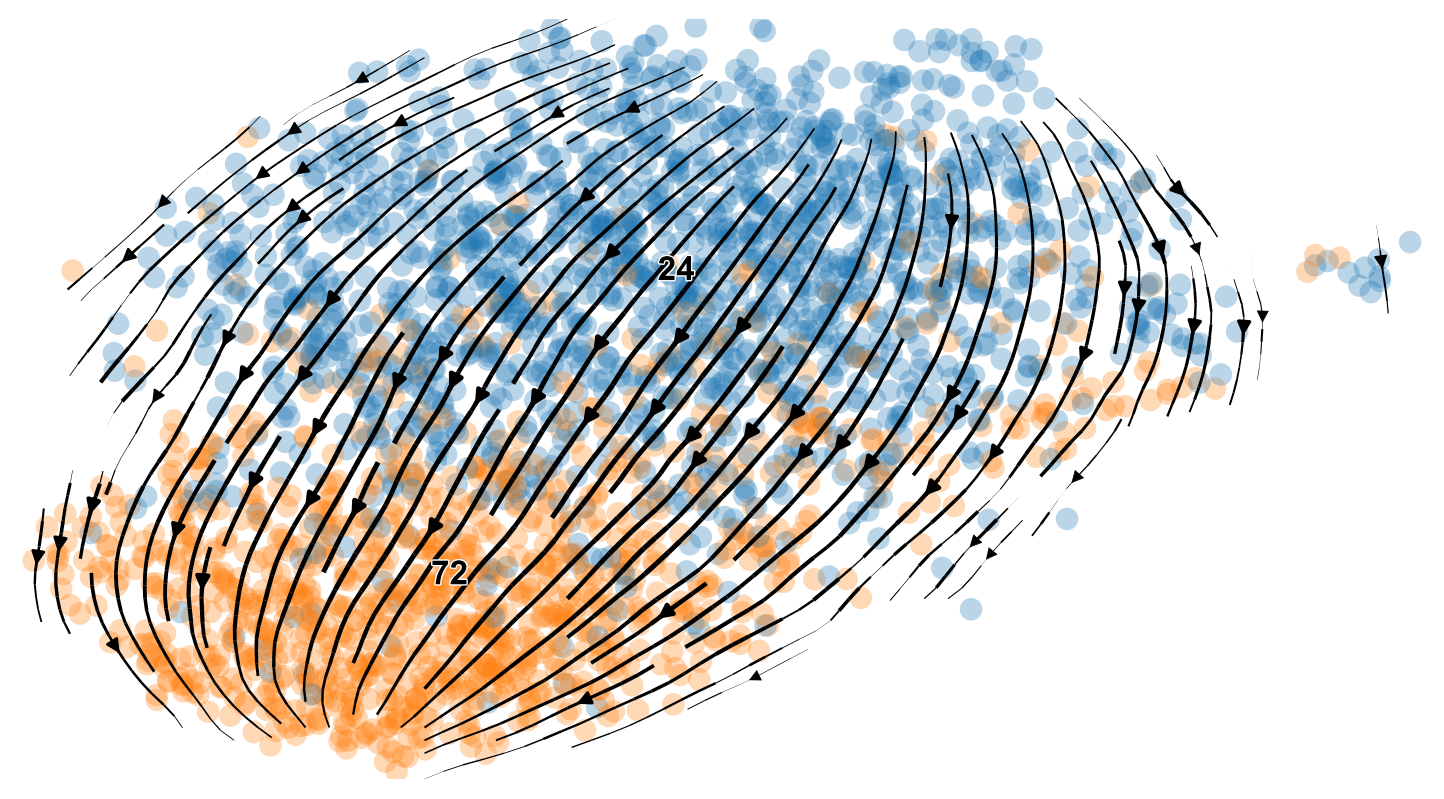

In [62]:
plt.rcParams["figure.figsize"] = (9,5) # (12,6)
scv.pl.velocity_embedding_stream(obs_adata, basis='umap', color="time", layer="obs", title="")

## Analyse most impacted genes for different drugs

In [63]:
mycellpop.interventional_model_prod

Sequential(
  (0): Linear(in_features=1024, out_features=4000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4000, out_features=4000, bias=True)
)

In [64]:
mycellpop.interventional_model_dec

Sequential(
  (0): Linear(in_features=1024, out_features=4000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4000, out_features=4000, bias=True)
)

In [65]:
all_prod_effects = {}
all_decay_effects = {}
for k, v in train_perts_with_fp_dict.items():
    drug_v = torch.Tensor(v)[None, :]
    prod_effect_drug_v = mycellpop.interventional_model_prod(drug_v)
    decay_effect_drug_v = mycellpop.interventional_model_dec(drug_v)

    all_prod_effects[k] = prod_effect_drug_v[0].detach().numpy()
    all_decay_effects[k] = decay_effect_drug_v[0].detach().numpy()


In [66]:
list(all_prod_effects.keys())

['AMG-900',
 'Abexinostat (PCI-24781)',
 'Alisertib (MLN8237)',
 'Barasertib (AZD1152-HQPA)',
 'Belinostat (PXD101)',
 'CUDC-101',
 'CYC116',
 'Cediranib (AZD2171)',
 'Cerdulatinib (PRT062070, PRT2070)',
 'Entinostat (MS-275)',
 'Enzastaurin (LY317615)',
 'Filgotinib (GLPG0634)',
 'Fluorouracil (5-Fluoracil, 5-FU)',
 'Hesperadin',
 'MK-5108 (VX-689)',
 'Momelotinib (CYT387)',
 'Motesanib Diphosphate (AMG-706)',
 'Obatoclax Mesylate (GX15-070)',
 'PHA-680632',
 'Panobinostat (LBH589)',
 'Pirarubicin',
 'Raltitrexed',
 'Roxadustat (FG-4592)',
 'Ruxolitinib (INCB018424)',
 'SRT2104 (GSK2245840)',
 'Tacedinaline (CI994)',
 'Thiotepa',
 'Trichostatin A (TSA)',
 'Tucidinostat (Chidamide)',
 'ZM 447439']

In [67]:
cleanest_effect_drugs = ['Abexinostat (PCI-24781)',
                        'Belinostat (PXD101)',
                        'Cerdulatinib (PRT062070, PRT2070)',
                        'Entinostat (MS-275)',
                        'Fluorouracil (5-Fluoracil, 5-FU)',
                        'Panobinostat (LBH589)',
                        'Trichostatin A (TSA)',
                        'Tucidinostat (Chidamide)']

In [187]:
for drug in cleanest_effect_drugs:
    abs_effects = np.abs(all_prod_effects[drug])
    ind = np.argsort(abs_effects)[-33:]

    most_affected_genes = [adata.var.index[i] for i in ind]

    with open('genes_prod_' + drug + '.txt', 'w') as f:
        for gene in most_affected_genes:
            f.write(f"{gene}\n")

In [188]:
for drug in cleanest_effect_drugs:
    abs_effects = np.abs(all_decay_effects[drug])
    ind = np.argsort(abs_effects)[-33:]

    most_affected_genes = [adata.var.index[i] for i in ind]

    with open('genes_decay_' + drug + '.txt', 'w') as f:
        for gene in most_affected_genes:
            f.write(f"{gene}\n")

In [33]:
for drug in cleanest_effect_drugs:
    abs_effects = np.abs(all_decay_effects[drug] + all_prod_effects[drug])
    ind = np.argsort(abs_effects)[-33:]

    most_affected_genes = [adata.var.index[i] for i in ind]

    with open('genes_sum_' + drug + '.txt', 'w') as f:
        for gene in most_affected_genes:
            f.write(f"{gene}\n")

In [34]:
for drug in cleanest_effect_drugs:
    abs_effects = np.abs(all_decay_effects[drug])
    ind = np.argsort(abs_effects)[-10:]

    most_affected_genes = [adata.var.index[i] for i in ind]

    with open('genes_10_decay_' + drug + '.txt', 'w') as f:
        for gene in most_affected_genes:
            f.write(f"{gene}\n")

In [70]:
for drug in cleanest_effect_drugs:
    abs_effects = np.abs(all_decay_effects[drug])
    ind = np.argsort(abs_effects)[-100:]

    most_affected_genes = [adata.var.index[i] for i in ind]

    with open('genes_100_decay_' + drug + '.txt', 'w') as f:
        for gene in most_affected_genes:
            f.write(f"{gene}\n")

## DE genes

In [68]:
gene_names = list(adata.var.index)

In [ ]:
with open('all_genes.txt', 'w') as f:
    for gene in gene_names:
        f.write(f"{gene}\n")

In [219]:
import random 
random.seed(0)
rand_subsamp_genes = random.sample(gene_names, 33)

with open('rand_subsamp_genes.txt', 'w') as f:
    for gene in rand_subsamp_genes:
        f.write(f"{gene}\n")

In [69]:
import random 
random.seed(0)
rand_subsamp_genes = random.sample(gene_names, 10)

with open('rand_subsamp_10_genes.txt', 'w') as f:
    for gene in rand_subsamp_genes:
        f.write(f"{gene}\n")

In [71]:
import random 
random.seed(0)
rand_subsamp_genes = random.sample(gene_names, 100)

with open('rand_subsamp_100_genes.txt', 'w') as f:
    for gene in rand_subsamp_genes:
        f.write(f"{gene}\n")

In [189]:
for drug in cleanest_effect_drugs:
    adata_drug_DE = adata[adata.obs["perturbation"].apply(lambda x: x in ["control", drug])]
    sc.pp.log1p(adata_drug_DE)
    sc.tl.rank_genes_groups(adata_drug_DE, 'perturbation', method='t-test', key_added = "t-test")

    abs_scores_drug_ttests = {adata_drug_DE.uns["t-test"]['names'][drug][i]: 
                       np.abs(adata_drug_DE.uns["t-test"]['scores'][drug][i])
                       for i in range(len(adata_drug_DE.uns["t-test"]['names'][drug]))}

    # Sort dictionary according to value
    abs_scores_drug_ttests = {k: v for k, v in sorted(abs_scores_drug_ttests.items(), key=lambda item: -item[1])}

    de_genes_drug = list(abs_scores_drug_ttests)[:33]
    with open('DE_genes_' + drug + '.txt', 'w') as f:
        for gene in de_genes_drug:
            f.write(f"{gene}\n")


In [37]:
for drug in cleanest_effect_drugs:
    adata_drug_DE = adata[adata.obs["perturbation"].apply(lambda x: x in ["control", drug])]
    sc.pp.log1p(adata_drug_DE)
    sc.tl.rank_genes_groups(adata_drug_DE, 'perturbation', method='t-test', key_added = "t-test")

    abs_scores_drug_ttests = {adata_drug_DE.uns["t-test"]['names'][drug][i]: 
                       np.abs(adata_drug_DE.uns["t-test"]['scores'][drug][i])
                       for i in range(len(adata_drug_DE.uns["t-test"]['names'][drug]))}

    # Sort dictionary according to value
    abs_scores_drug_ttests = {k: v for k, v in sorted(abs_scores_drug_ttests.items(), key=lambda item: -item[1])}

    de_genes_drug = list(abs_scores_drug_ttests)[:10]
    with open('DE_genes_10_' + drug + '.txt', 'w') as f:
        for gene in de_genes_drug:
            f.write(f"{gene}\n")


In [104]:
adata_LBH589 = adata[adata.obs["perturbation"].apply(lambda x: x in ["control", 'Panobinostat (LBH589)'])]
sc.pp.log1p(adata_LBH589)
sc.tl.rank_genes_groups(adata_LBH589, 'perturbation', method='t-test', key_added = "t-test")

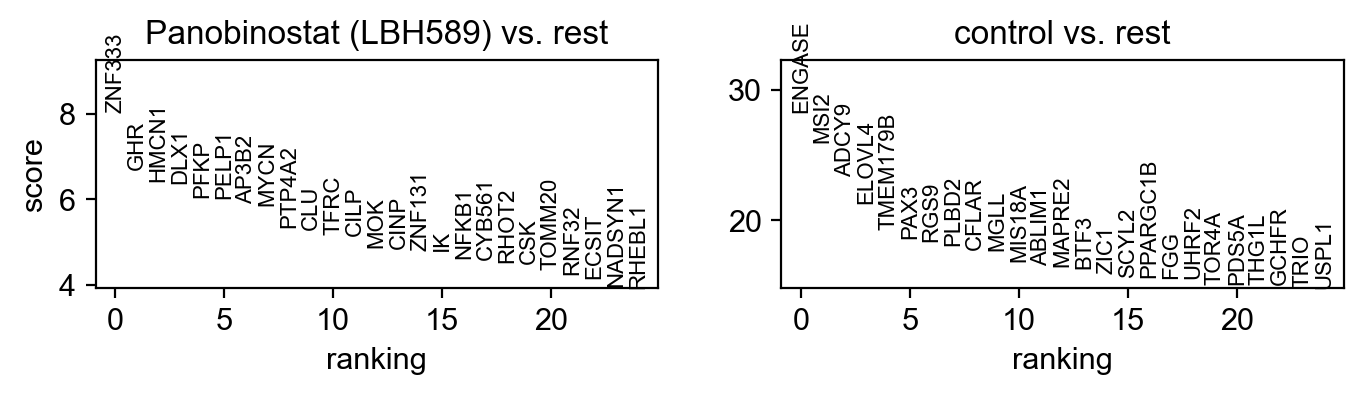

In [105]:
sc.pl.rank_genes_groups(adata_LBH589, n_genes=25, sharey=False, key = "t-test")

In [106]:
abs_scores_LBH589_ttests = {adata_LBH589.uns["t-test"]['names']['Panobinostat (LBH589)'][i]: 
                       np.abs(adata_LBH589.uns["t-test"]['scores']['Panobinostat (LBH589)'][i])
                       for i in range(len(adata_LBH589.uns["t-test"]['names']['Panobinostat (LBH589)']))}

# Sort dictionary according to value
abs_scores_LBH589_ttests = {k: v for k, v in sorted(abs_scores_LBH589_ttests.items(), key=lambda item: -item[1])}


In [107]:
abs_scores_LBH589_ttests

{'ENGASE': 28.206375,
 'MSI2': 25.965654,
 'ADCY9': 23.38539,
 'ELOVL4': 21.277746,
 'TMEM179B': 19.27956,
 'PAX3': 18.577084,
 'RGS9': 18.38871,
 'PLBD2': 18.071262,
 'CFLAR': 17.75676,
 'MGLL': 17.665586,
 'MIS18A': 16.84556,
 'ABLIM1': 16.512451,
 'MAPRE2': 16.50034,
 'BTF3': 16.282171,
 'ZIC1': 15.910883,
 'SCYL2': 15.699575,
 'PPARGC1B': 15.60816,
 'FGG': 15.56664,
 'UHRF2': 15.545865,
 'TOR4A': 15.110397,
 'PDS5A': 15.100774,
 'THG1L': 15.0988655,
 'GCHFR': 15.092505,
 'TRIO': 14.843137,
 'USPL1': 14.805361,
 'SLC36A1': 14.704102,
 'DHRS1': 14.633968,
 'TIMM8B': 14.572022,
 'DUSP11': 14.283495,
 'CRP': 14.043391,
 'CCNI': 13.929516,
 'FSD1L': 13.922485,
 'URB2': 13.785515,
 'WTIP': 13.724429,
 'POLR1D': 13.676656,
 'PSAP': 13.545217,
 'SLC38A4': 13.513268,
 'KHK': 13.455957,
 'LIMK1': 13.382047,
 'CACNA1D': 13.257964,
 'FASTKD2': 13.138077,
 'TAF2': 13.039761,
 'KATNB1': 13.02169,
 'KLC4': 12.887992,
 'PTGR1': 12.681134,
 'IRF4': 12.629859,
 'CTDP1': 12.484322,
 'NAT14': 12.47878

## Plot distributions

In [ ]:
cleanest_effect_drugs = ['Abexinostat (PCI-24781)',
                        'Belinostat (PXD101)',
                        'Cerdulatinib (PRT062070, PRT2070)',
                        'Entinostat (MS-275)',
                        'Fluorouracil (5-Fluoracil, 5-FU)',
                        'Panobinostat (LBH589)',
                        'Trichostatin A (TSA)',
                        'Tucidinostat (Chidamide)']

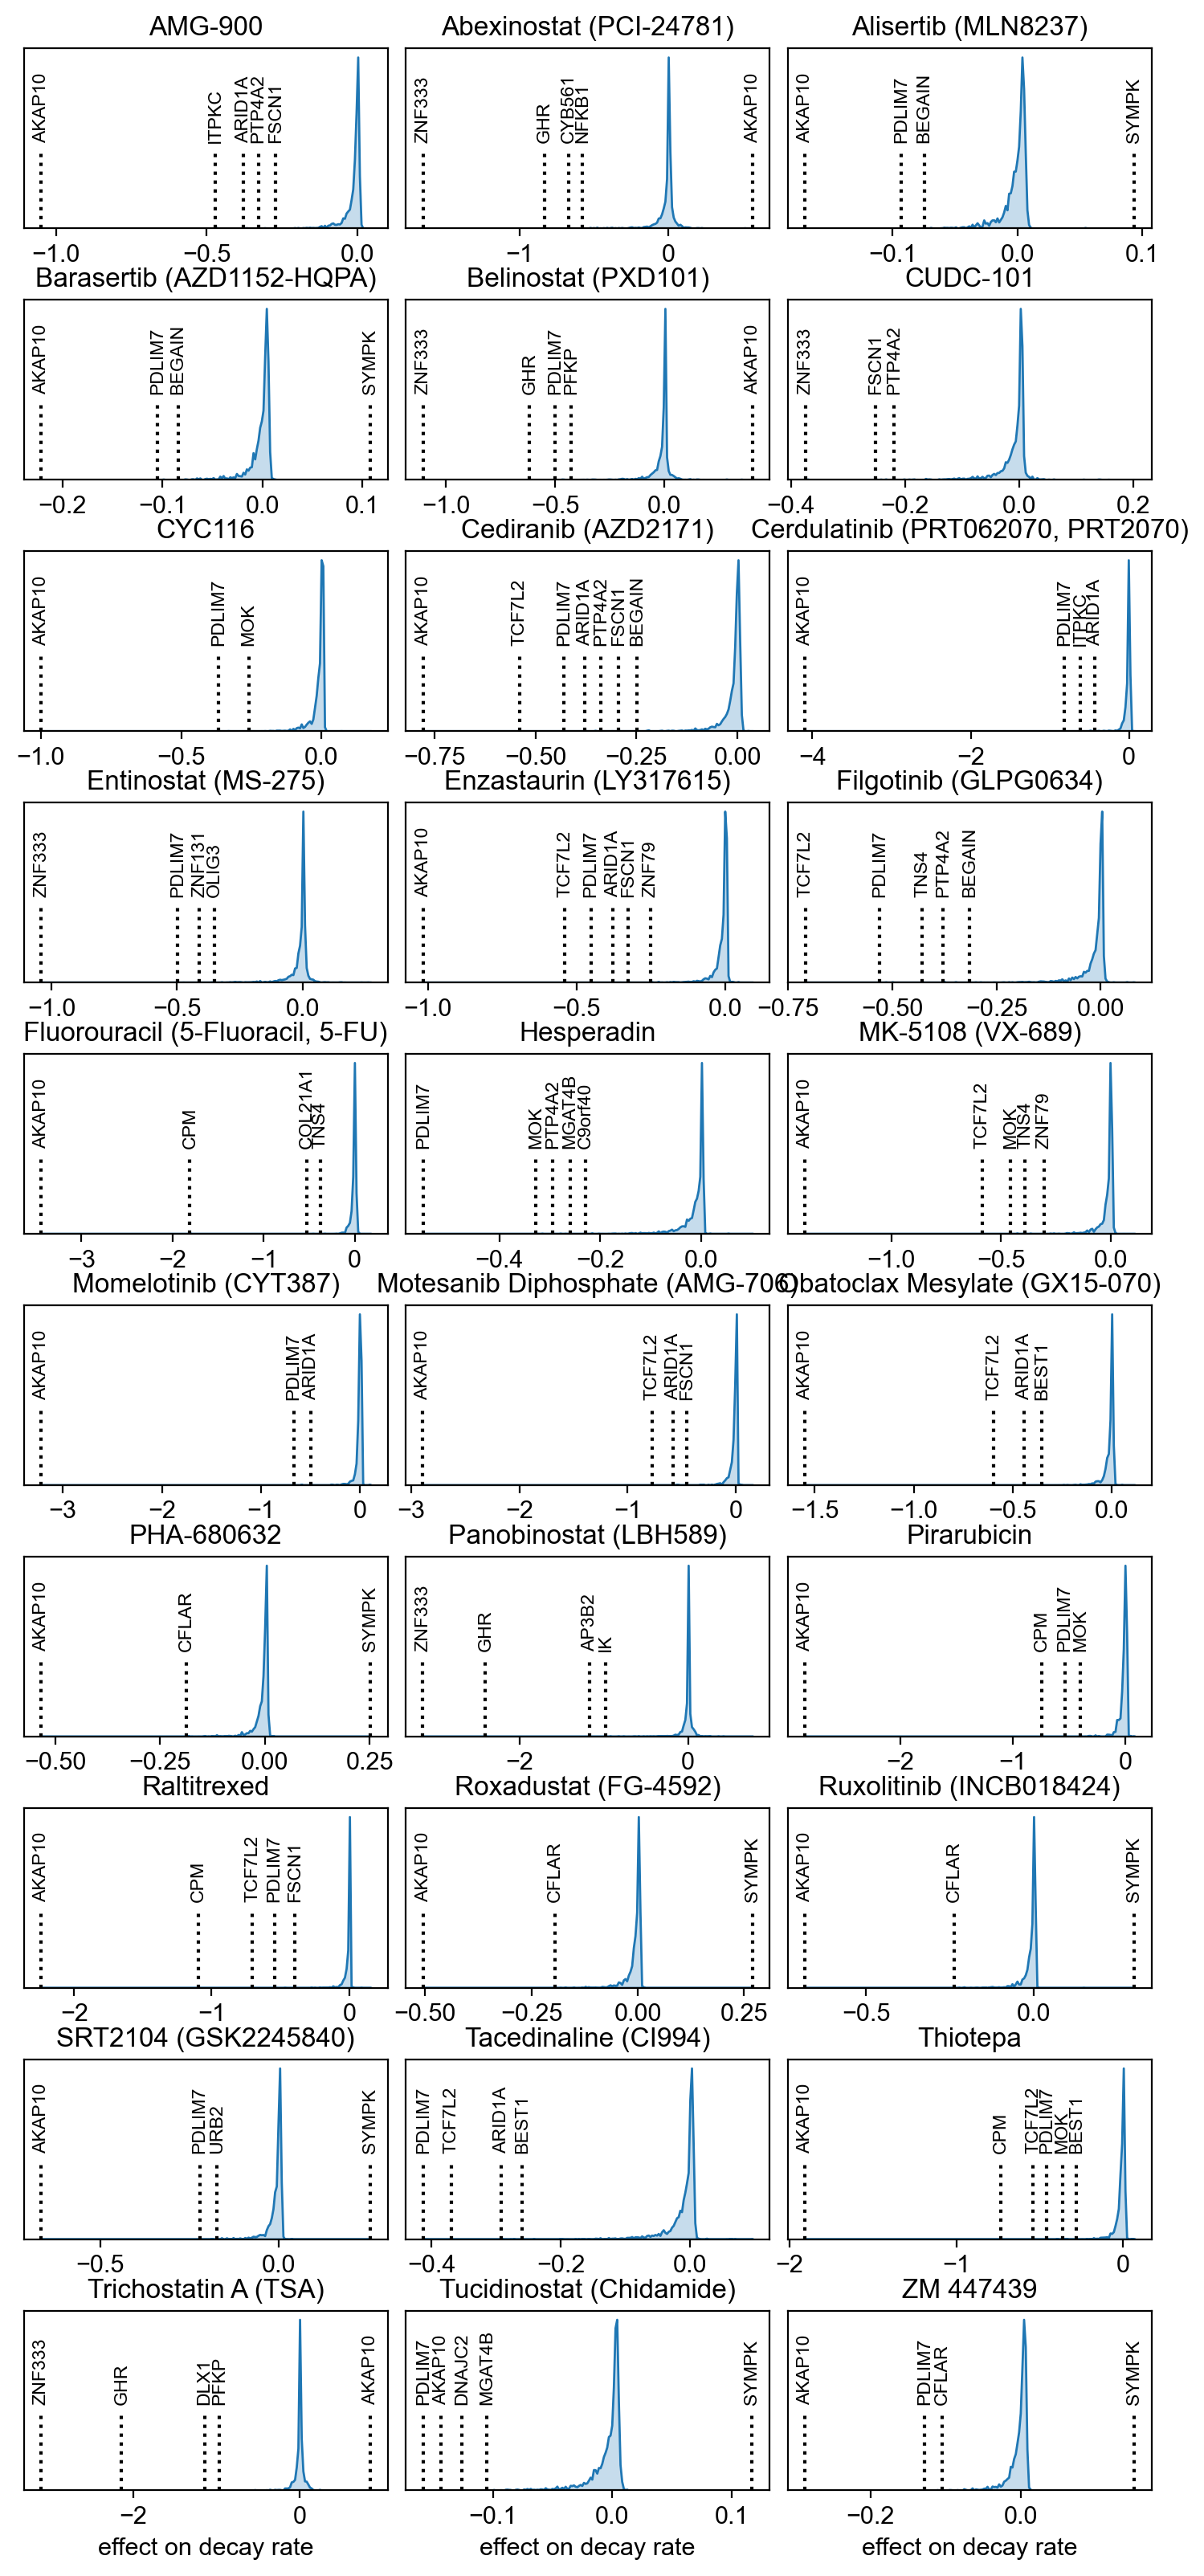

In [171]:
f, axes = plt.subplots(10, 3, figsize=(9, 20), sharex=False, sharey=False)
cpt = 0

for k, v in all_decay_effects.items():
    ax_k = cpt // 3
    ax_l = cpt % 3
    # plt.rcParams["figure.figsize"] = (4, 1.5)
    g = sns.kdeplot(v, bw_adjust=.1, fill=True, ax=axes[ax_k, ax_l])
    if ax_k == 9:
        g.set_xlabel("effect on decay rate")
    g.set_ylabel("")
    g.set_title(k)
    g.set_yticks([])

    # Plot names of most affected genes
    ind = np.argsort(np.abs(v))[-50:]
    most_affected_names = [adata.var.index[i] for i in ind]
    most_affected_effect = v[ind]

    prev_plotted_effects = []
    thres = (g.dataLim.x1 - g.dataLim.x0) / 25

    for i in range(10):
        if not prev_plotted_effects or np.min([np.abs(most_affected_effect[- 1 -i] - e) for e in prev_plotted_effects])  > thres:
            g.text(most_affected_effect[- 1 -i], g.dataLim.y1 / 2., most_affected_names[- 1 -i], rotation=90, verticalalignment='bottom', horizontalalignment='center', fontsize='x-small')
            g.vlines(most_affected_effect[- 1 -i], ymin=0., ymax=(g.dataLim.y1 / 2.)*0.9, ls=':', colors="k")
            prev_plotted_effects.append(most_affected_effect[- 1 -i])

    cpt += 1

plt.subplots_adjust(wspace=0.05, hspace=0.4)
plt.show()


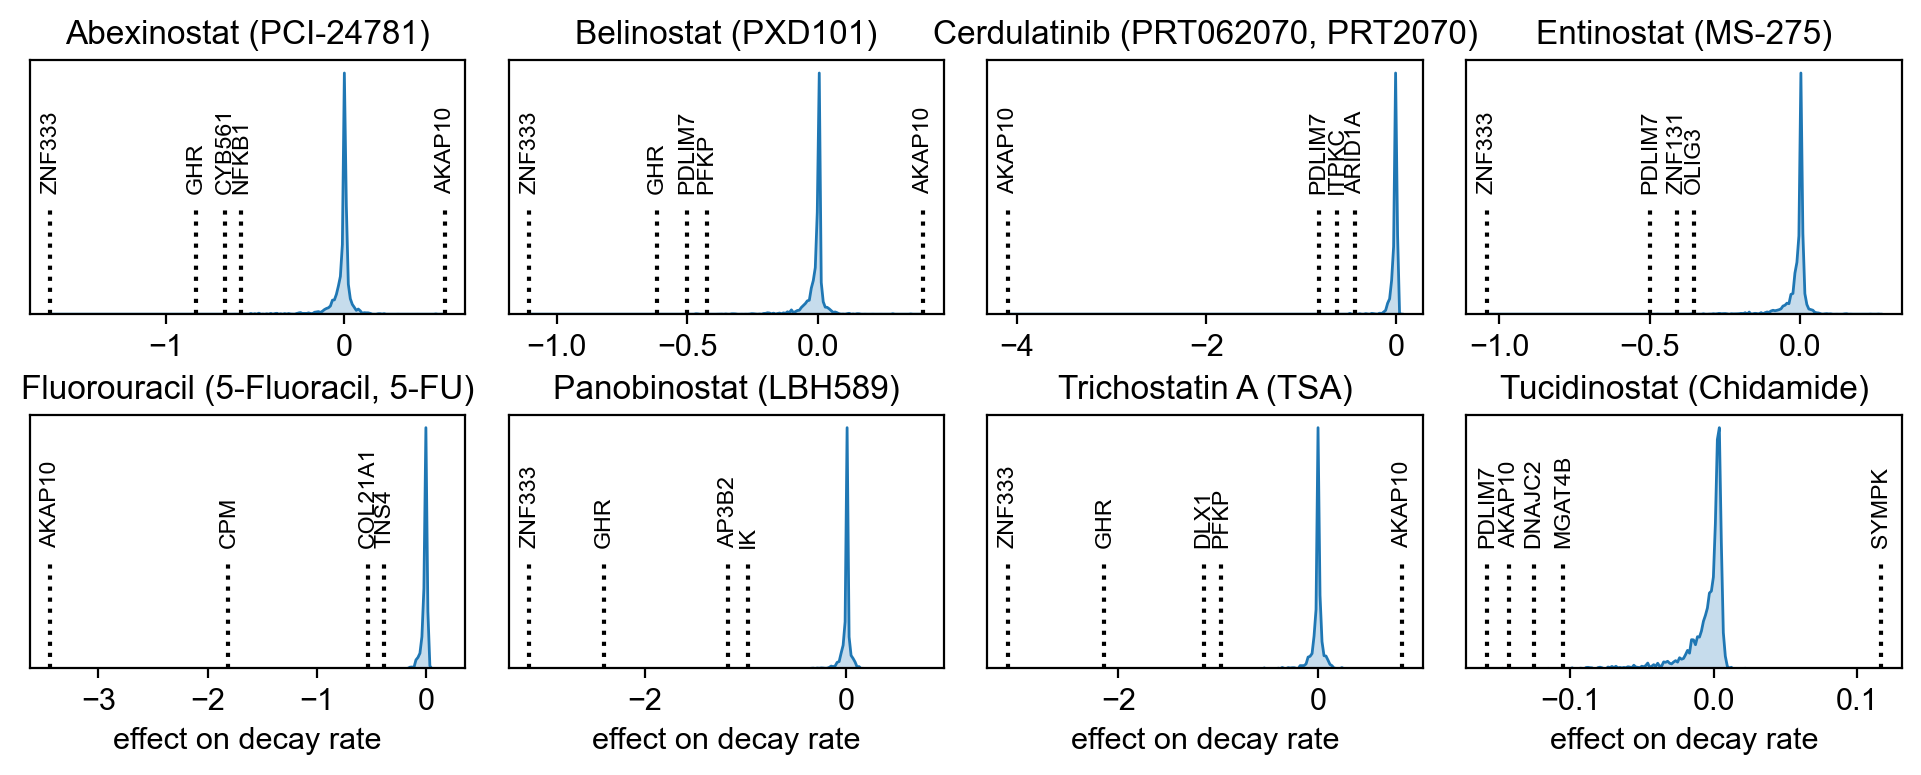

In [183]:
f, axes = plt.subplots(2, 4, figsize=(12, 4), sharex=False, sharey=False)
cpt = 0

for k in cleanest_effect_drugs:
    v = all_decay_effects[k]
    ax_k = cpt // 4
    ax_l = cpt % 4
    g = sns.kdeplot(v, bw_adjust=.1, fill=True, ax=axes[ax_k, ax_l])
    if ax_k == 1:
        g.set_xlabel("effect on decay rate")
    g.set_ylabel("")
    g.set_title(k)
    g.set_yticks([])

    # Plot names of most affected genes
    ind = np.argsort(np.abs(v))[-50:]
    most_affected_names = [adata.var.index[i] for i in ind]
    most_affected_effect = v[ind]

    prev_plotted_effects = []
    thres = (g.dataLim.x1 - g.dataLim.x0) / 25

    for i in range(10):
        if not prev_plotted_effects or np.min([np.abs(most_affected_effect[- 1 -i] - e) for e in prev_plotted_effects])  > thres:
            g.text(most_affected_effect[- 1 -i], g.dataLim.y1 / 2., most_affected_names[- 1 -i], rotation=90, verticalalignment='bottom', horizontalalignment='center', fontsize='x-small')
            g.vlines(most_affected_effect[- 1 -i], ymin=0., ymax=(g.dataLim.y1 / 2.)*0.9, ls=':', colors="k")
            prev_plotted_effects.append(most_affected_effect[- 1 -i])

    cpt += 1

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()


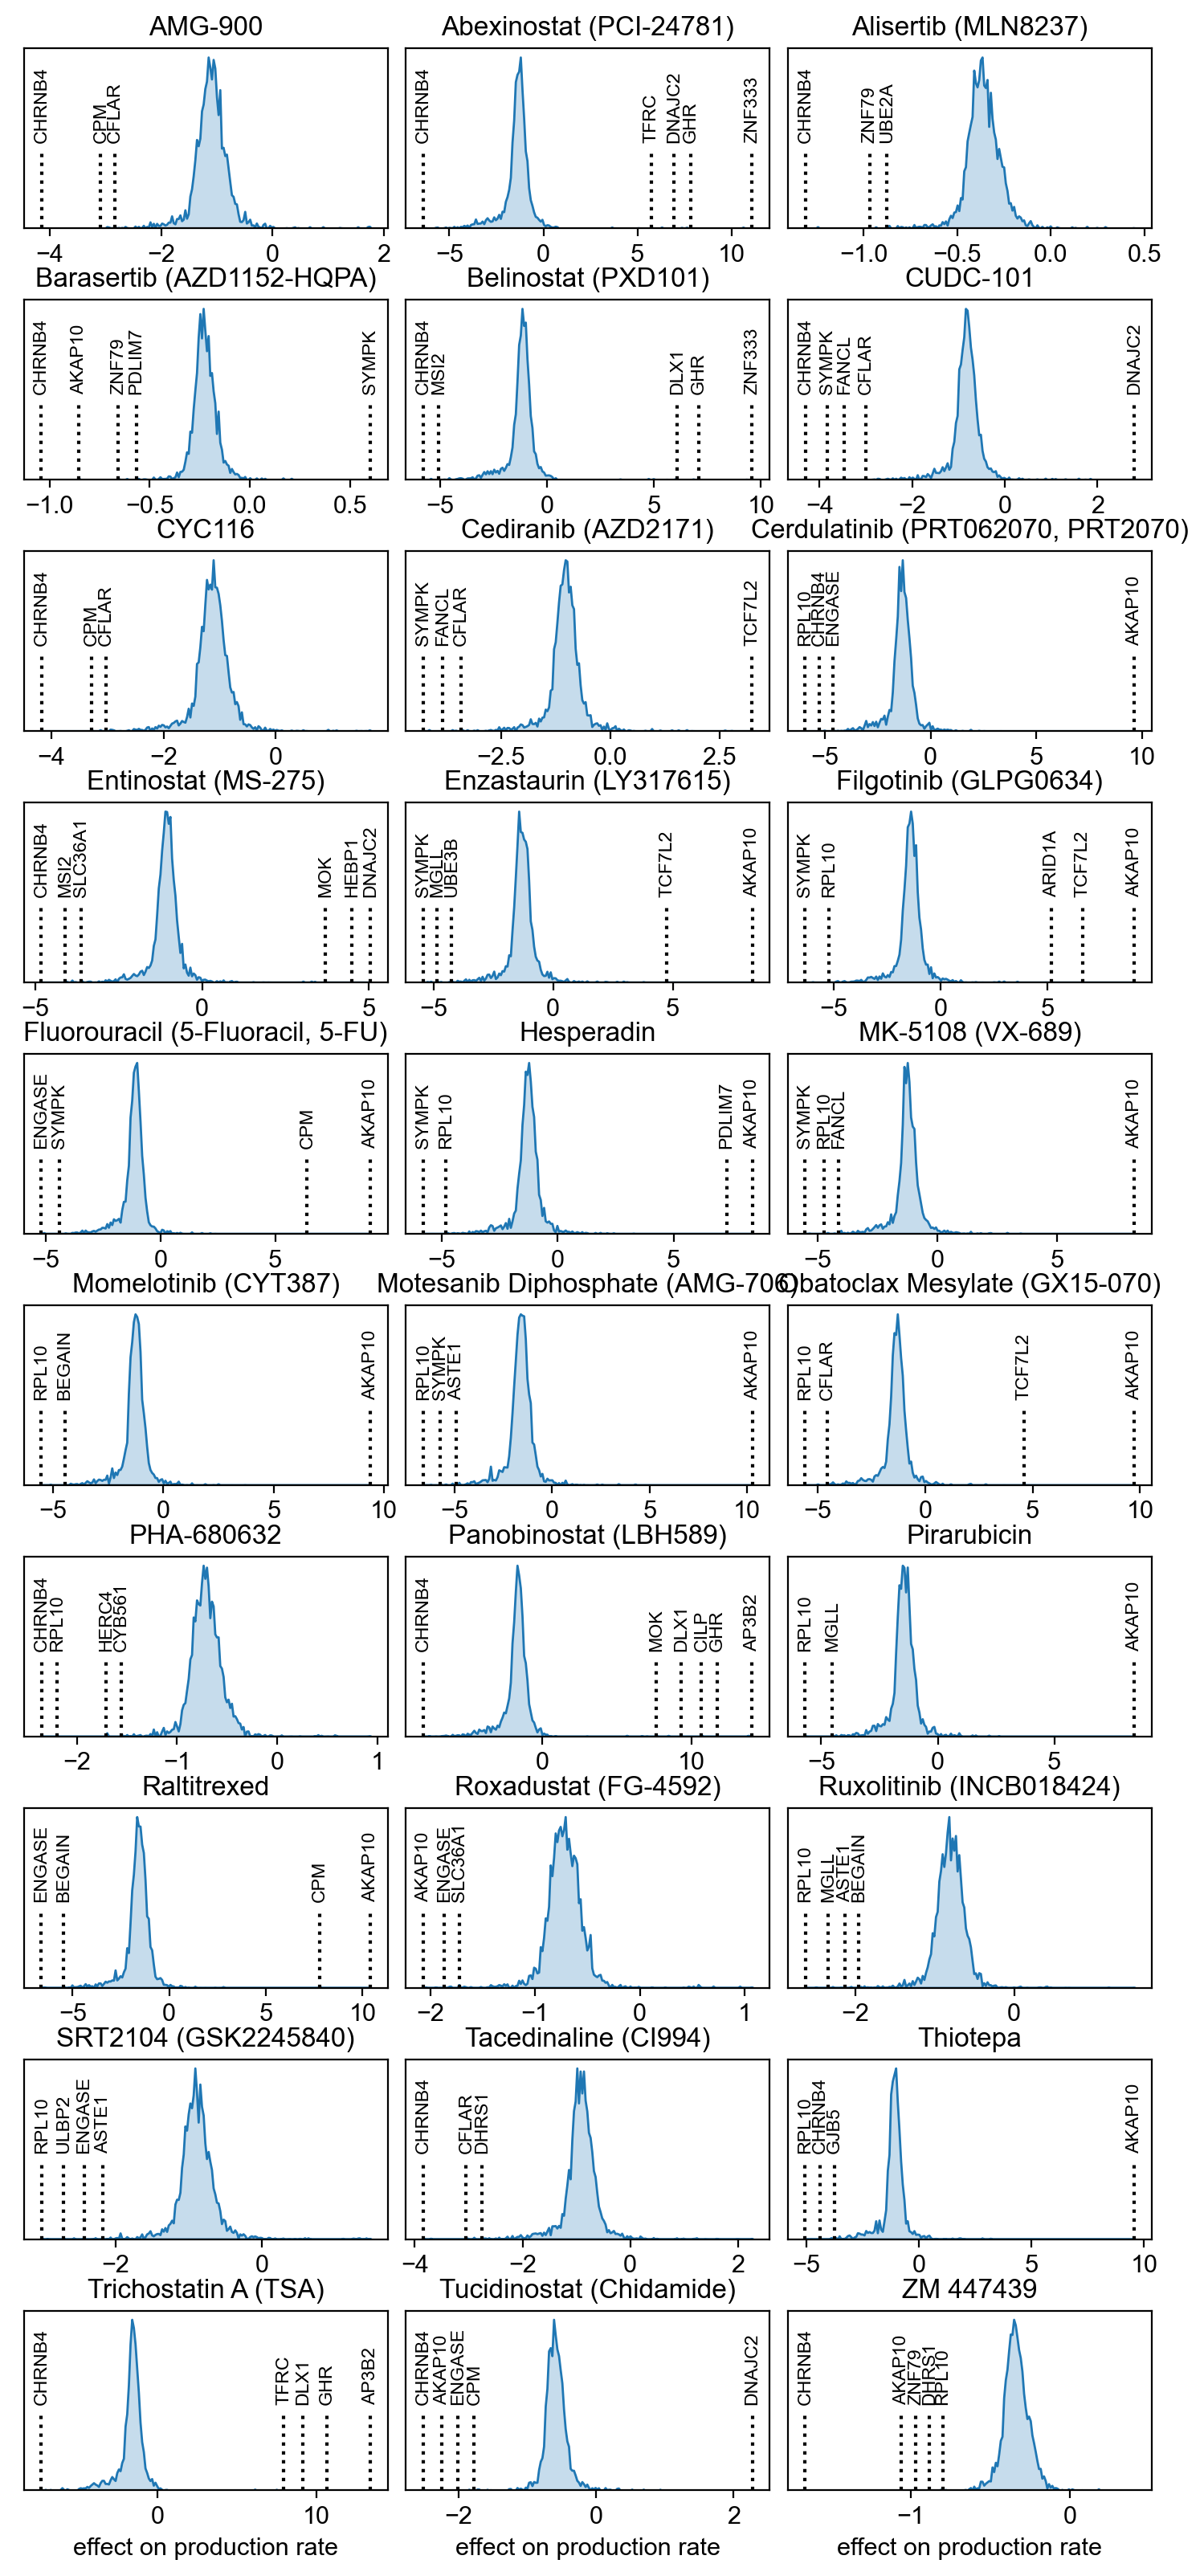

In [172]:
f, axes = plt.subplots(10, 3, figsize=(9, 20), sharex=False, sharey=False)
cpt = 0

for k, v in all_prod_effects.items():
    ax_k = cpt // 3
    ax_l = cpt % 3
    # plt.rcParams["figure.figsize"] = (4, 1.5)
    g = sns.kdeplot(v, bw_adjust=.1, fill=True, ax=axes[ax_k, ax_l])
    if ax_k == 9:
        g.set_xlabel("effect on production rate")
    g.set_ylabel("")
    g.set_title(k)
    g.set_yticks([])

    # Plot names of most affected genes
    ind = np.argsort(np.abs(v))[-50:]
    most_affected_names = [adata.var.index[i] for i in ind]
    most_affected_effect = v[ind]

    prev_plotted_effects = []
    thres = (g.dataLim.x1 - g.dataLim.x0) / 25

    for i in range(10):
        if not prev_plotted_effects or np.min([np.abs(most_affected_effect[- 1 -i] - e) for e in prev_plotted_effects])  > thres:
            g.text(most_affected_effect[- 1 -i], g.dataLim.y1 / 2., most_affected_names[- 1 -i], rotation=90, verticalalignment='bottom', horizontalalignment='center', fontsize='x-small')
            g.vlines(most_affected_effect[- 1 -i], ymin=0., ymax=(g.dataLim.y1 / 2.)*0.9, ls=':', colors="k")
            prev_plotted_effects.append(most_affected_effect[- 1 -i])

    cpt += 1

plt.subplots_adjust(wspace=0.05, hspace=0.4)
plt.show()


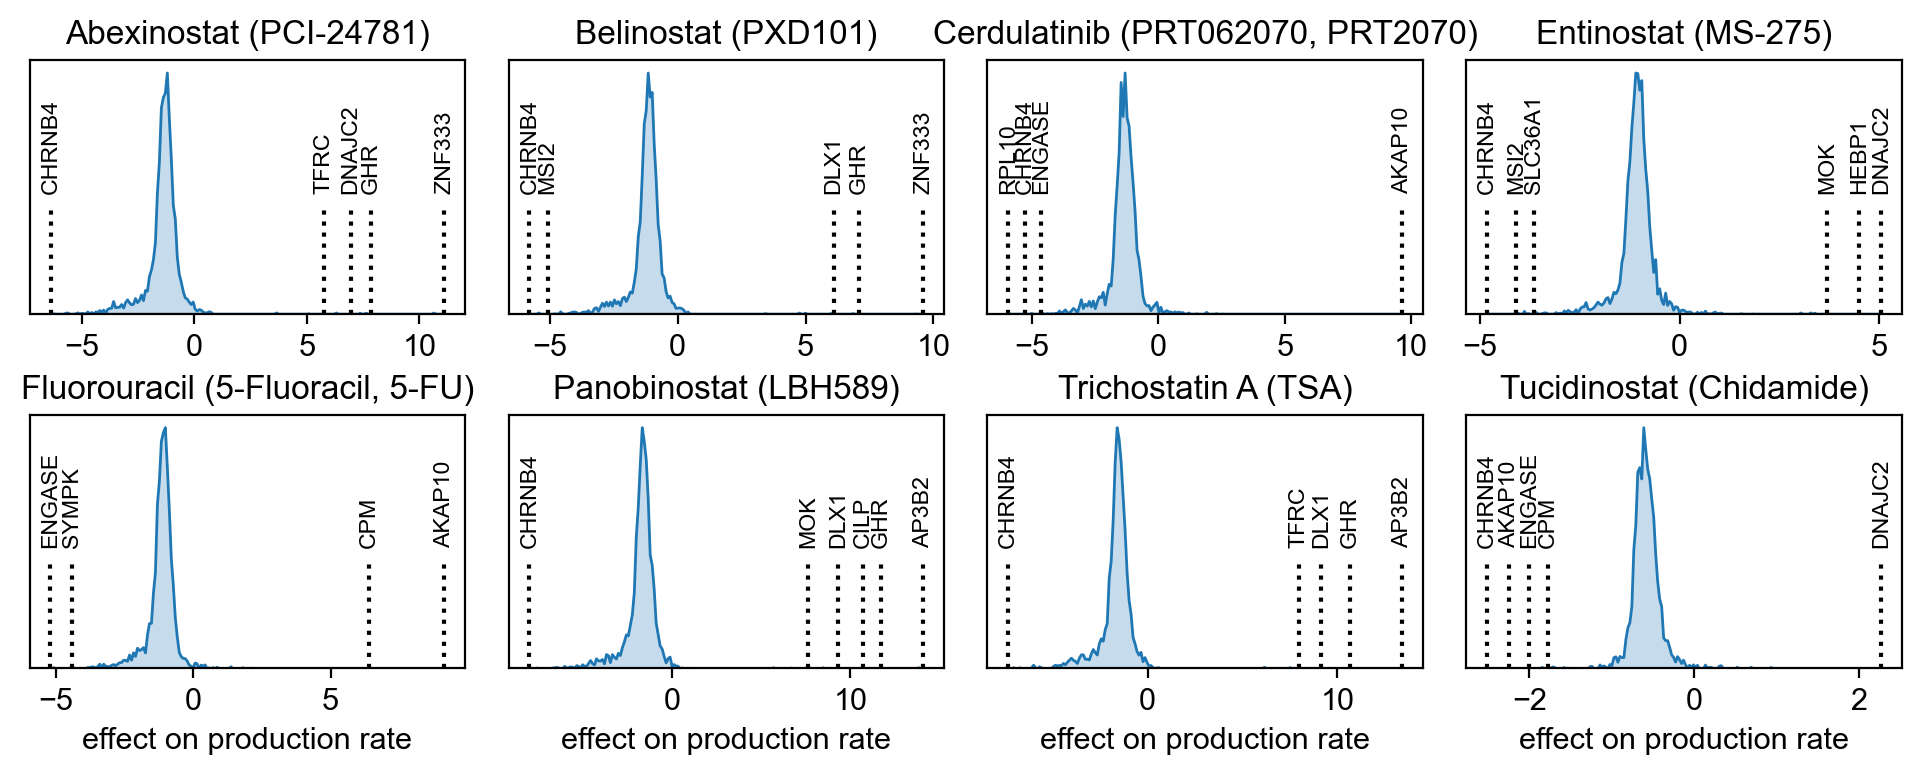

In [184]:
f, axes = plt.subplots(2, 4, figsize=(12, 4), sharex=False, sharey=False)
cpt = 0

for k in cleanest_effect_drugs:
    v = all_prod_effects[k]
    ax_k = cpt // 4
    ax_l = cpt % 4
    g = sns.kdeplot(v, bw_adjust=.1, fill=True, ax=axes[ax_k, ax_l])
    if ax_k == 1:
        g.set_xlabel("effect on production rate")
    g.set_ylabel("")
    g.set_title(k)
    g.set_yticks([])

    # Plot names of most affected genes
    ind = np.argsort(np.abs(v))[-50:]
    most_affected_names = [adata.var.index[i] for i in ind]
    most_affected_effect = v[ind]

    prev_plotted_effects = []
    thres = (g.dataLim.x1 - g.dataLim.x0) / 25

    for i in range(10):
        if not prev_plotted_effects or np.min([np.abs(most_affected_effect[- 1 -i] - e) for e in prev_plotted_effects])  > thres:
            g.text(most_affected_effect[- 1 -i], g.dataLim.y1 / 2., most_affected_names[- 1 -i], rotation=90, verticalalignment='bottom', horizontalalignment='center', fontsize='x-small')
            g.vlines(most_affected_effect[- 1 -i], ymin=0., ymax=(g.dataLim.y1 / 2.)*0.9, ls=':', colors="k")
            prev_plotted_effects.append(most_affected_effect[- 1 -i])

    cpt += 1

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()


## Simulate trajectories

In [72]:
out_sample_obs_cells = np.unique([x[0] for x in train_dataset_pert_paths[out_sample_indices, 1]])
start_adata = adata[out_sample_obs_cells]


In [73]:
start_adata

View of AnnData object with n_obs × n_vars = 590 × 4000
    obs: 'cell_barcode', 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'n_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'gene_name', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '(+)-JQ1_shortest_paths', '2-Methoxyestradiol (2-MeOE2)_shortest_paths', 'AG-14361_shortest_paths', 'AMG-900_shortest_paths', 'AT9283_shortest_paths', 'Abexinostat (PCI-24781)_shortest_paths', 'Alisertib (MLN8237)_shortest_paths', 'BMS-265246_shortest_paths', 'Barasertib (AZD1152-HQPA)_shortest_paths', 'Belinostat (PXD101)_shortest_paths', 'CUDC-101_shortest_paths', 'CYC116_shortest_paths', 'Carmofur_shortest_paths', 'Cediranib (AZD2171)_shortest_paths',

In [74]:
start_adata.shape[0] / 10

59.0

In [75]:
batch_size = start_adata.shape[0] // 10
mycellpop.change_batch_size(batch_size)

In [76]:
mycellpop

CellPopulation. 4000 nodes and 59 cells.

In [77]:
torch.linspace(0, 1, 10)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [78]:
path_length = 2
all_traj = []

with torch.no_grad():

    for i in tqdm(range(start_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(start_adata.X[i*batch_size: (i + 1)*batch_size, :, None]).to(device)
        
        mycellpop.set_visible_state(gene_expr)
        
        traj = simulate_deterministic_trajectory(mycellpop, torch.linspace(0, path_length-1, 10))
        traj = traj[:, :, :mycellpop.n_genes, 0]

        all_traj.append(traj)
        
#         if i == 4:
#             break

100%|██████████| 10/10 [08:01<00:00, 48.16s/it]


In [79]:
all_traj_cat = torch.cat(all_traj)

In [80]:
obs_times = torch.cat([torch.linspace(0, path_length-1, 10)[None]]*len(all_traj_cat)).reshape(-1).numpy()

In [81]:
traj_adata = ad.AnnData(all_traj_cat.reshape(-1, 4000).cpu().numpy(), obs=obs_times)

In [82]:
traj_adata.obs = traj_adata.obs.rename(columns={0: "time"})

In [83]:
sc.tl.pca(traj_adata)
sc.pp.neighbors(traj_adata, n_neighbors=50)
sc.tl.umap(traj_adata, maxiter=600)

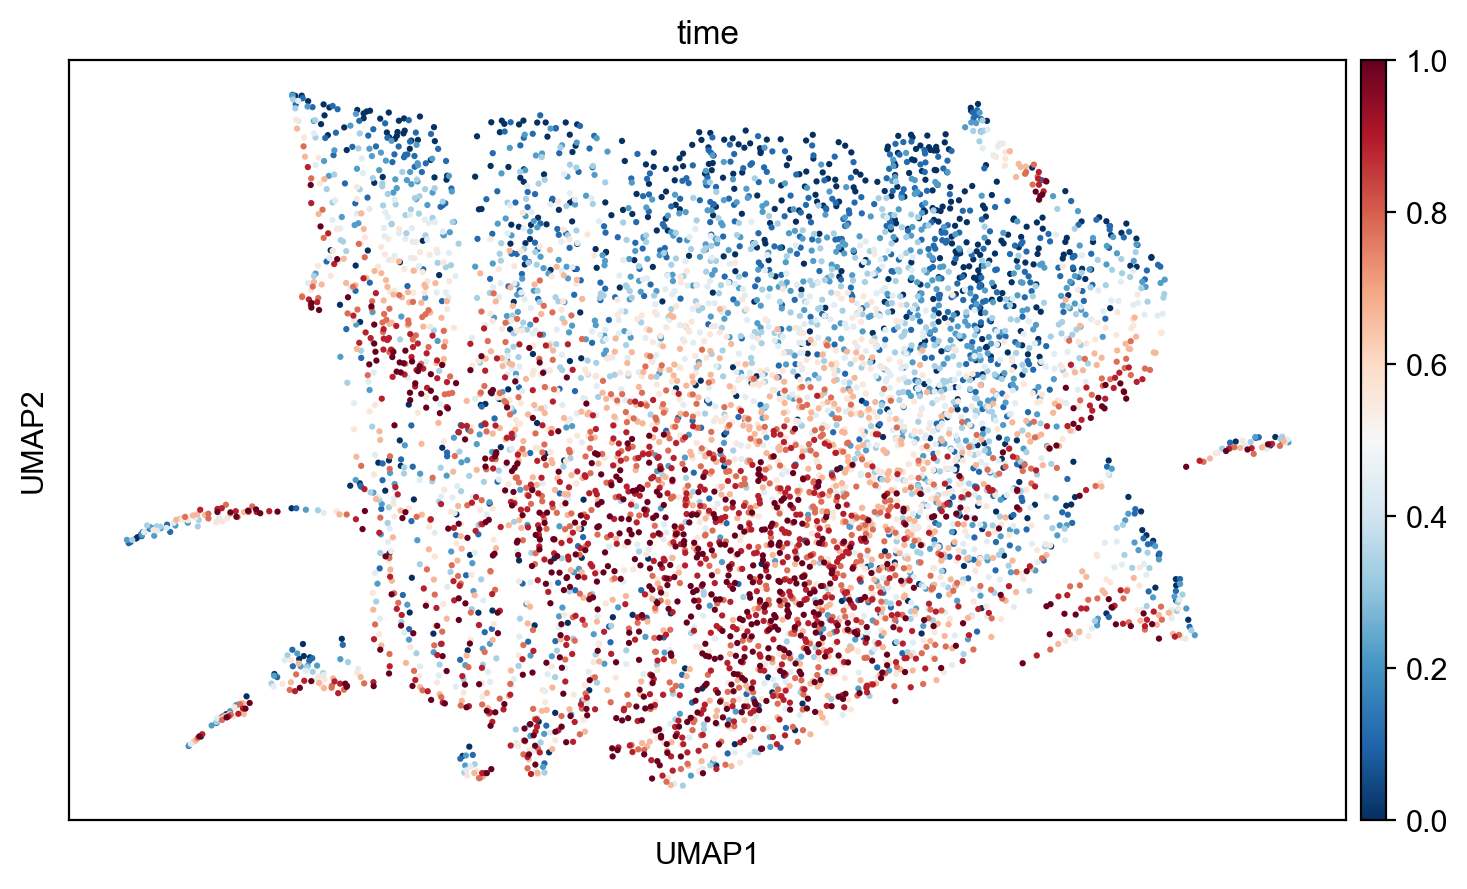

In [84]:
sc.pl.umap(traj_adata, color="time")

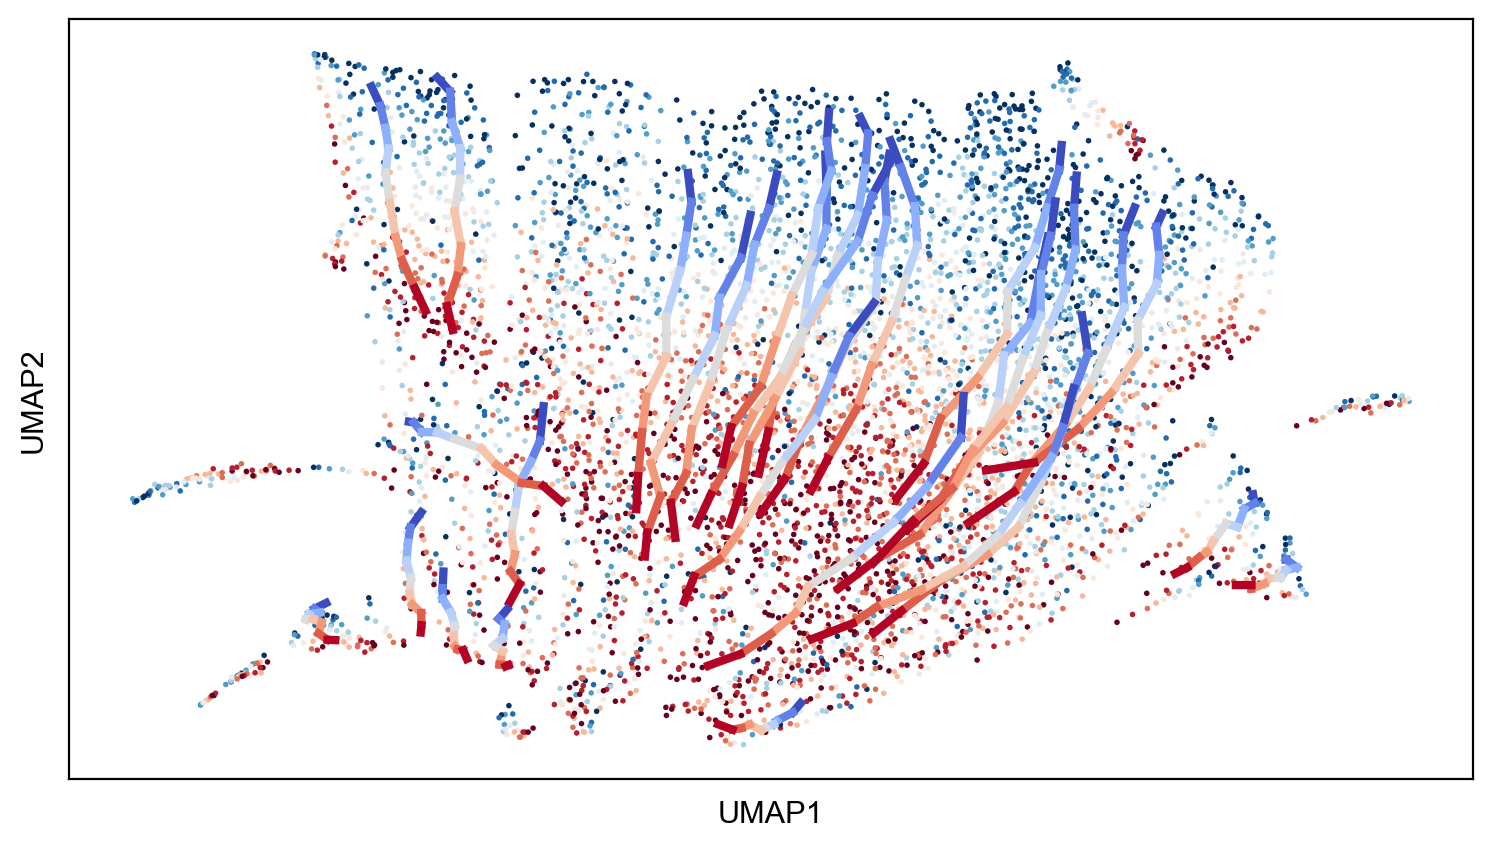

In [85]:
n_traj = len(traj_adata) // 10
selected_trajs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=30)]

plt.scatter(traj_adata.obsm["X_umap"][:, 0], traj_adata.obsm["X_umap"][:, 1], c=traj_adata.obs["time"], s=1)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.xticks([])
plt.yticks([])

cmap = plt.get_cmap("coolwarm")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs:
    for i in range(n_colors):
        plt.plot(traj_adata.obsm["X_umap"][traj[i:i+2], 0], traj_adata.obsm["X_umap"][traj[i:i+2], 1], c=colors[i], linewidth=3)
plt.show()

## Simulate interventional trajectories

In [87]:
path_length = 10
all_traj_abex = []

mycellpop.intervene(torch.tensor(train_perts_with_fp_dict['Abexinostat (PCI-24781)'])[None, :].to(device))

with torch.no_grad():

    for i in tqdm(range(start_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(start_adata.X[i*batch_size: (i + 1)*batch_size, :, None]).to(device)
        
        mycellpop.set_visible_state(gene_expr)
        
        traj = simulate_deterministic_trajectory(mycellpop, torch.linspace(0, path_length-1, 10))
        traj = traj[:, :, :mycellpop.n_genes, 0]

        all_traj_abex.append(traj)
        
#         if i == 4:
#             break

100%|██████████| 10/10 [25:35<00:00, 153.53s/it]


In [88]:
path_length = 10
all_traj_belin = []

mycellpop.intervene(torch.tensor(train_perts_with_fp_dict['Belinostat (PXD101)'])[None, :].to(device))

with torch.no_grad():

    for i in tqdm(range(start_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(start_adata.X[i*batch_size: (i + 1)*batch_size, :, None]).to(device)
        
        mycellpop.set_visible_state(gene_expr)
        
        traj = simulate_deterministic_trajectory(mycellpop, torch.linspace(0, path_length-1, 10))
        traj = traj[:, :, :mycellpop.n_genes, 0]

        all_traj_belin.append(traj)
        
#         if i == 4:
#             break

100%|██████████| 10/10 [24:05<00:00, 144.52s/it]


In [395]:
all_traj_cat = torch.cat(all_traj)
all_traj_abex_cat = torch.cat(all_traj_abex)
all_traj_belin_cat = torch.cat(all_traj_belin)

In [397]:
all_traj_cat.shape

torch.Size([590, 10, 4000])

In [398]:
obs_times = torch.cat([torch.linspace(0, path_length-1, 10)[None]]*len(all_traj_cat)).reshape(-1).numpy()

In [399]:
traj_adata = ad.AnnData(all_traj_cat.reshape(-1, 4000).cpu().numpy(), obs=obs_times)

In [400]:
traj_adata_abex = ad.AnnData(all_traj_abex_cat.reshape(-1, 4000).cpu().numpy(), obs=obs_times)

In [401]:
traj_adata_belin = ad.AnnData(all_traj_belin_cat.reshape(-1, 4000).cpu().numpy(), obs=obs_times)

In [402]:
traj_adata.obs["perturbation"] = "control"
traj_adata_abex.obs["perturbation"] = "Abexinostat"
traj_adata_belin.obs["perturbation"] = "Belinostat"

In [403]:
all_traj_adata = ad.concat([ 
    traj_adata, 
    traj_adata_abex, 
    traj_adata_belin
    ])

In [404]:
all_traj_adata.shape

(17700, 4000)

In [405]:
all_traj_adata.obs = all_traj_adata.obs.rename(columns={0: "time"})

In [406]:
sc.tl.pca(all_traj_adata)
sc.pp.neighbors(all_traj_adata, n_neighbors=100)

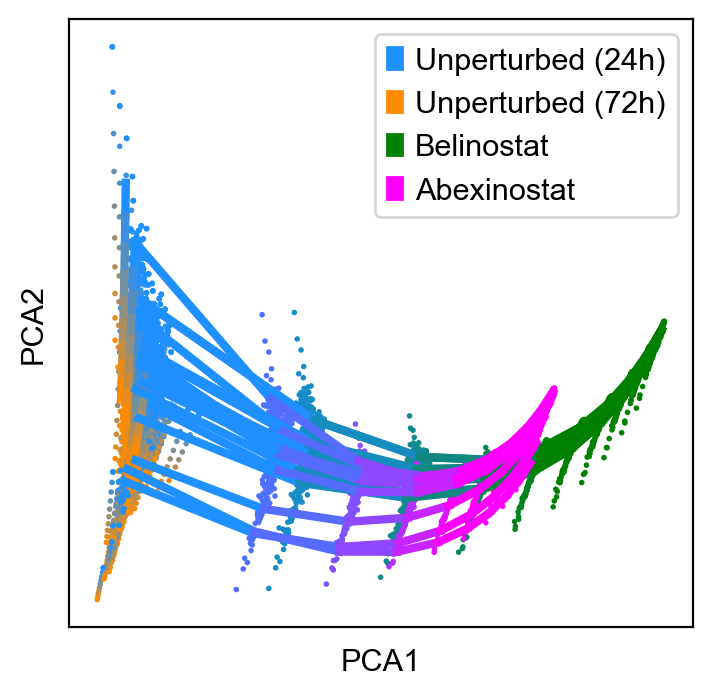

In [458]:
plt.rcParams["figure.figsize"] = (4,4)
n_traj = len(all_traj_cat) // 10

pca_comp_1 = 0
pca_comp_2 = 1

cmap_1 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "darkorange"])
cmap_2 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "green", "green"])
cmap_3 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "magenta", "magenta"])


selected_trajs_obs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_abex = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_belin = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]

control_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "control"]
plt.scatter(control_trajs.obsm["X_pca"][:, pca_comp_1], control_trajs.obsm["X_pca"][:, pca_comp_2], c=control_trajs.obs["time"], s=1, cmap=cmap_1)

abex_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Abexinostat"]
plt.scatter(abex_trajs.obsm["X_pca"][:, pca_comp_1], abex_trajs.obsm["X_pca"][:, pca_comp_2], c=abex_trajs.obs["time"], s=1, cmap=cmap_2)

belin_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Belinostat"]
plt.scatter(belin_trajs.obsm["X_pca"][:, pca_comp_1], belin_trajs.obsm["X_pca"][:, pca_comp_2], c=belin_trajs.obs["time"], s=1, cmap=cmap_3)


plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.xticks([])
plt.yticks([])

cmap = cmap_1
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_obs:
    for i in range(n_colors):
        plt.plot(control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = cmap_2
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_abex:
    for i in range(n_colors):
        plt.plot(abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = cmap_3
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_belin:
    for i in range(n_colors):
        plt.plot(belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

blue_patch = mpatches.Patch(color='dodgerblue', label='Unperturbed (24h)')
orange_patch = mpatches.Patch(color='darkorange', label='Unperturbed (72h)')
green_patch = mpatches.Patch(color='green', label='Belinostat')
magenta_patch = mpatches.Patch(color='magenta', label='Abexinostat')
plt.legend(handles=[blue_patch, orange_patch, green_patch, magenta_patch])

plt.show()

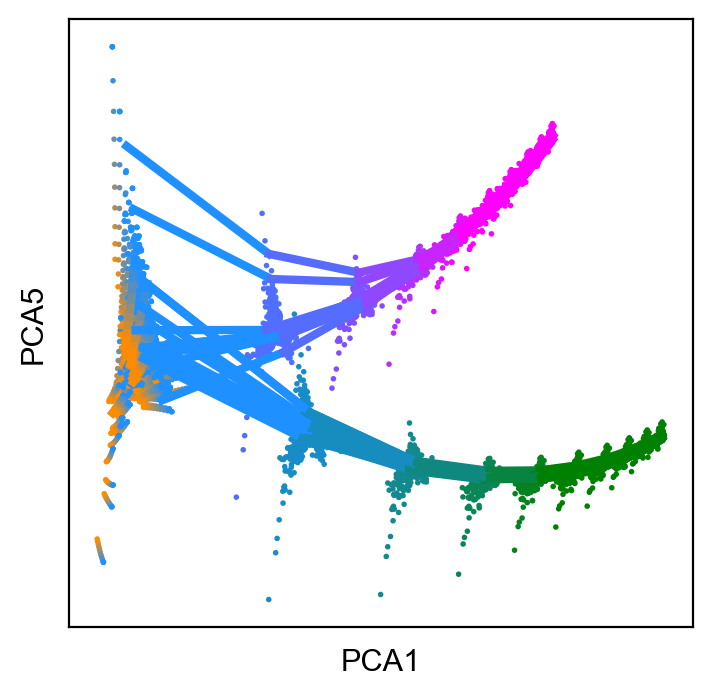

In [459]:
plt.rcParams["figure.figsize"] = (4,4)
n_traj = len(all_traj_cat) // 10

pca_comp_1 = 0
pca_comp_2 = 4

cmap_1 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "darkorange"])
cmap_2 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "green", "green"])
cmap_3 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "magenta", "magenta"])


selected_trajs_obs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_abex = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_belin = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]

control_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "control"]
plt.scatter(control_trajs.obsm["X_pca"][:, pca_comp_1], control_trajs.obsm["X_pca"][:, pca_comp_2], c=control_trajs.obs["time"], s=1, cmap=cmap_1)

abex_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Abexinostat"]
plt.scatter(abex_trajs.obsm["X_pca"][:, pca_comp_1], abex_trajs.obsm["X_pca"][:, pca_comp_2], c=abex_trajs.obs["time"], s=1, cmap=cmap_2)

belin_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Belinostat"]
plt.scatter(belin_trajs.obsm["X_pca"][:, pca_comp_1], belin_trajs.obsm["X_pca"][:, pca_comp_2], c=belin_trajs.obs["time"], s=1, cmap=cmap_3)


plt.xlabel("PCA1")
plt.ylabel("PCA5")
plt.xticks([])
plt.yticks([])

cmap = cmap_1
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_obs:
    for i in range(n_colors):
        plt.plot(control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = cmap_2
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_abex:
    for i in range(n_colors):
        plt.plot(abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = cmap_3
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_belin:
    for i in range(n_colors):
        plt.plot(belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

plt.show()

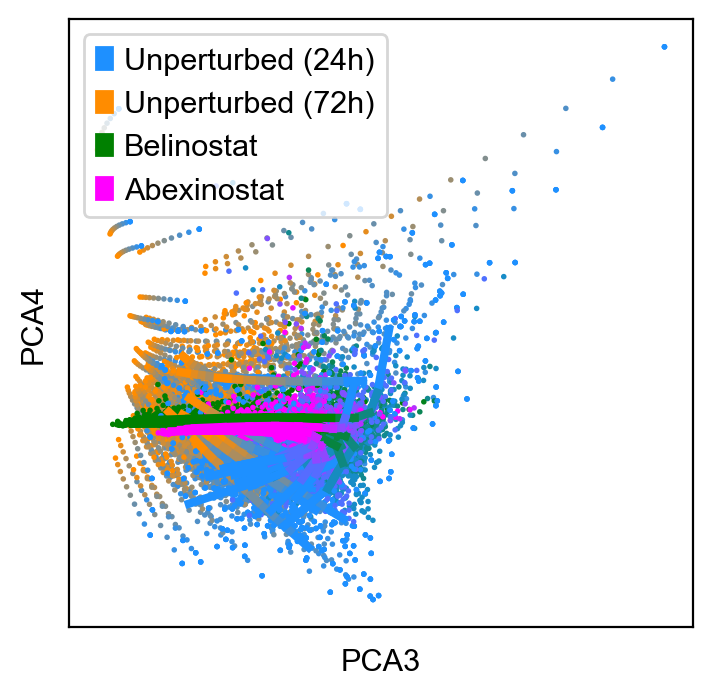

In [462]:
plt.rcParams["figure.figsize"] = (4,4)
n_traj = len(all_traj_cat) // 10

pca_comp_1 = 2
pca_comp_2 = 3

cmap_1 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "darkorange"])
cmap_2 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "green", "green"])
cmap_3 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "magenta", "magenta"])


selected_trajs_obs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_abex = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_belin = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]

control_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "control"]
plt.scatter(control_trajs.obsm["X_pca"][:, pca_comp_1], control_trajs.obsm["X_pca"][:, pca_comp_2], c=control_trajs.obs["time"], s=1, cmap=cmap_1)

abex_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Abexinostat"]
plt.scatter(abex_trajs.obsm["X_pca"][:, pca_comp_1], abex_trajs.obsm["X_pca"][:, pca_comp_2], c=abex_trajs.obs["time"], s=1, cmap=cmap_2)

belin_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Belinostat"]
plt.scatter(belin_trajs.obsm["X_pca"][:, pca_comp_1], belin_trajs.obsm["X_pca"][:, pca_comp_2], c=belin_trajs.obs["time"], s=1, cmap=cmap_3)


plt.xlabel("PCA3")
plt.ylabel("PCA4")
plt.xticks([])
plt.yticks([])

cmap = cmap_1
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_obs:
    for i in range(n_colors):
        plt.plot(control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = cmap_2
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_abex:
    for i in range(n_colors):
        plt.plot(abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = cmap_3
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_belin:
    for i in range(n_colors):
        plt.plot(belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

blue_patch = mpatches.Patch(color='dodgerblue', label='Unperturbed (24h)')
orange_patch = mpatches.Patch(color='darkorange', label='Unperturbed (72h)')
green_patch = mpatches.Patch(color='green', label='Belinostat')
magenta_patch = mpatches.Patch(color='magenta', label='Abexinostat')
plt.legend(handles=[blue_patch, orange_patch, green_patch, magenta_patch])

plt.show()

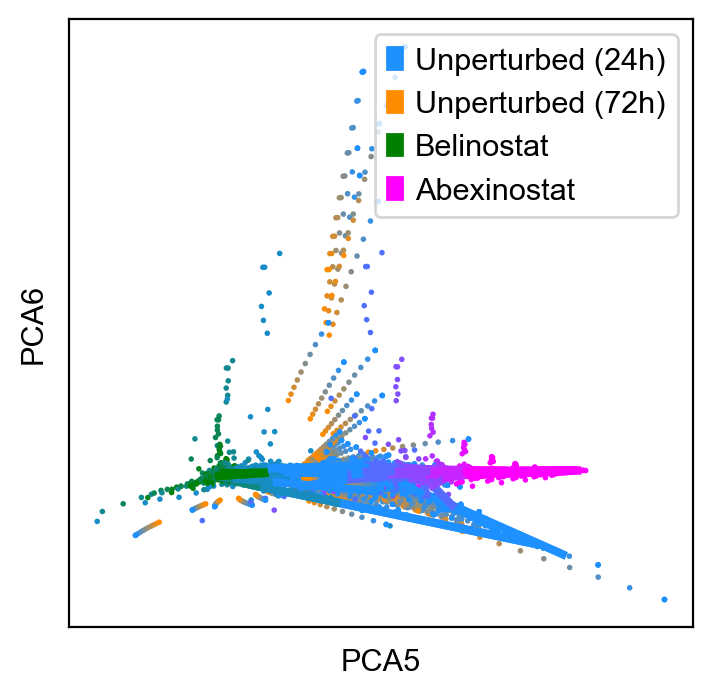

In [463]:
plt.rcParams["figure.figsize"] = (4,4)
n_traj = len(all_traj_cat) // 10

pca_comp_1 = 4
pca_comp_2 = 5

cmap_1 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "darkorange"])
cmap_2 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "green", "green"])
cmap_3 = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "magenta", "magenta"])


selected_trajs_obs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_abex = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_belin = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]

control_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "control"]
plt.scatter(control_trajs.obsm["X_pca"][:, pca_comp_1], control_trajs.obsm["X_pca"][:, pca_comp_2], c=control_trajs.obs["time"], s=1, cmap=cmap_1)

abex_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Abexinostat"]
plt.scatter(abex_trajs.obsm["X_pca"][:, pca_comp_1], abex_trajs.obsm["X_pca"][:, pca_comp_2], c=abex_trajs.obs["time"], s=1, cmap=cmap_2)

belin_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Belinostat"]
plt.scatter(belin_trajs.obsm["X_pca"][:, pca_comp_1], belin_trajs.obsm["X_pca"][:, pca_comp_2], c=belin_trajs.obs["time"], s=1, cmap=cmap_3)


plt.xlabel("PCA5")
plt.ylabel("PCA6")
plt.xticks([])
plt.yticks([])

cmap = cmap_1
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_obs:
    for i in range(n_colors):
        plt.plot(control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = cmap_2
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_abex:
    for i in range(n_colors):
        plt.plot(abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = cmap_3
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_belin:
    for i in range(n_colors):
        plt.plot(belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

blue_patch = mpatches.Patch(color='dodgerblue', label='Unperturbed (24h)')
orange_patch = mpatches.Patch(color='darkorange', label='Unperturbed (72h)')
green_patch = mpatches.Patch(color='green', label='Belinostat')
magenta_patch = mpatches.Patch(color='magenta', label='Abexinostat')
plt.legend(handles=[blue_patch, orange_patch, green_patch, magenta_patch])

plt.show()

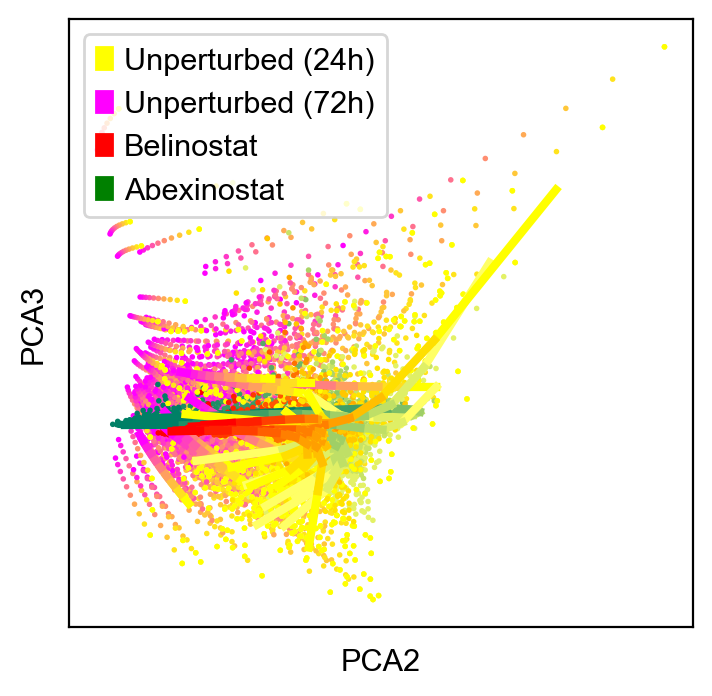

In [446]:
plt.rcParams["figure.figsize"] = (4,4)
n_traj = len(all_traj_cat) // 10

pca_comp_1 = 2
pca_comp_2 = 3


selected_trajs_obs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_abex = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_belin = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]

control_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "control"]
plt.scatter(control_trajs.obsm["X_pca"][:, pca_comp_1], control_trajs.obsm["X_pca"][:, pca_comp_2], c=control_trajs.obs["time"], s=1, cmap=plt.get_cmap("spring_r"))

abex_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Abexinostat"]
plt.scatter(abex_trajs.obsm["X_pca"][:, pca_comp_1], abex_trajs.obsm["X_pca"][:, pca_comp_2], c=abex_trajs.obs["time"], s=1, cmap=plt.get_cmap("summer_r"))

belin_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Belinostat"]
plt.scatter(belin_trajs.obsm["X_pca"][:, pca_comp_1], belin_trajs.obsm["X_pca"][:, pca_comp_2], c=belin_trajs.obs["time"], s=1, cmap=plt.get_cmap("autumn_r"))


plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.xticks([])
plt.yticks([])

cmap = plt.get_cmap("spring_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_obs:
    for i in range(n_colors):
        plt.plot(control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = plt.get_cmap("summer_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_abex:
    for i in range(n_colors):
        plt.plot(abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = plt.get_cmap("autumn_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_belin:
    for i in range(n_colors):
        plt.plot(belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

yellow_patch = mpatches.Patch(color='yellow', label='Unperturbed (24h)')
purple_patch = mpatches.Patch(color='magenta', label='Unperturbed (72h)')
red_patch = mpatches.Patch(color='red', label='Belinostat')
green_patch = mpatches.Patch(color='green', label='Abexinostat')
plt.legend(handles=[yellow_patch, purple_patch, red_patch, green_patch])

plt.show()

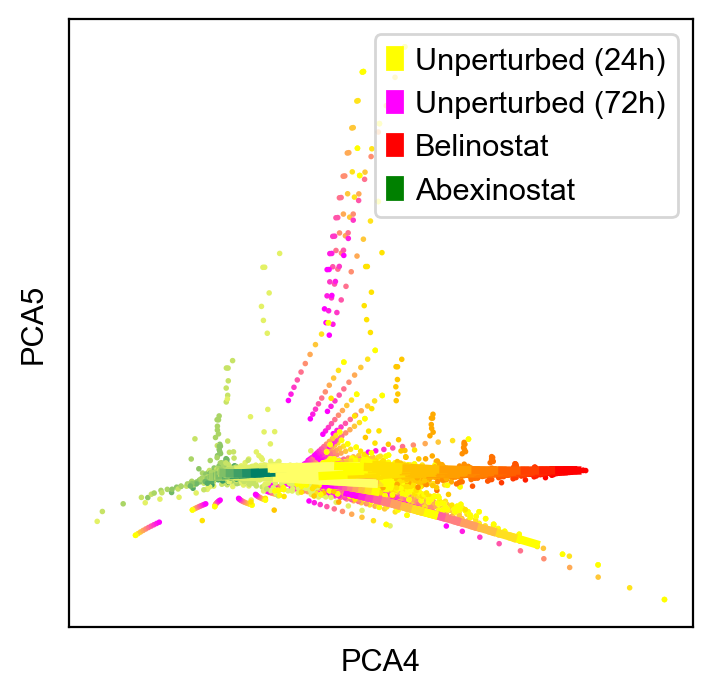

In [447]:
plt.rcParams["figure.figsize"] = (4,4)
n_traj = len(all_traj_cat) // 10

pca_comp_1 = 4
pca_comp_2 = 5


selected_trajs_obs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_abex = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_belin = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]

control_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "control"]
plt.scatter(control_trajs.obsm["X_pca"][:, pca_comp_1], control_trajs.obsm["X_pca"][:, pca_comp_2], c=control_trajs.obs["time"], s=1, cmap=plt.get_cmap("spring_r"))

abex_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Abexinostat"]
plt.scatter(abex_trajs.obsm["X_pca"][:, pca_comp_1], abex_trajs.obsm["X_pca"][:, pca_comp_2], c=abex_trajs.obs["time"], s=1, cmap=plt.get_cmap("summer_r"))

belin_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Belinostat"]
plt.scatter(belin_trajs.obsm["X_pca"][:, pca_comp_1], belin_trajs.obsm["X_pca"][:, pca_comp_2], c=belin_trajs.obs["time"], s=1, cmap=plt.get_cmap("autumn_r"))


plt.xlabel("PCA4")
plt.ylabel("PCA5")
plt.xticks([])
plt.yticks([])

cmap = plt.get_cmap("spring_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_obs:
    for i in range(n_colors):
        plt.plot(control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = plt.get_cmap("summer_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_abex:
    for i in range(n_colors):
        plt.plot(abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = plt.get_cmap("autumn_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_belin:
    for i in range(n_colors):
        plt.plot(belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

yellow_patch = mpatches.Patch(color='yellow', label='Unperturbed (24h)')
purple_patch = mpatches.Patch(color='magenta', label='Unperturbed (72h)')
red_patch = mpatches.Patch(color='red', label='Belinostat')
green_patch = mpatches.Patch(color='green', label='Abexinostat')
plt.legend(handles=[yellow_patch, purple_patch, red_patch, green_patch])

plt.show()

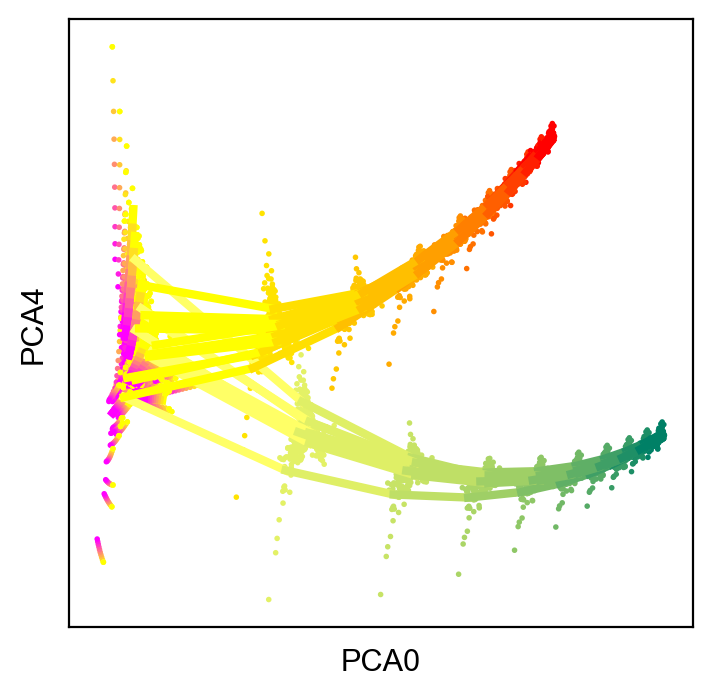

In [443]:
plt.rcParams["figure.figsize"] = (4,4)
n_traj = len(all_traj_cat) // 10

pca_comp_1 = 0 # 0
pca_comp_2 = 4 # 4


selected_trajs_obs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_abex = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_belin = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]

control_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "control"]
plt.scatter(control_trajs.obsm["X_pca"][:, pca_comp_1], control_trajs.obsm["X_pca"][:, pca_comp_2], c=control_trajs.obs["time"], s=1, cmap=plt.get_cmap("spring_r"))

abex_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Abexinostat"]
plt.scatter(abex_trajs.obsm["X_pca"][:, pca_comp_1], abex_trajs.obsm["X_pca"][:, pca_comp_2], c=abex_trajs.obs["time"], s=1, cmap=plt.get_cmap("summer_r"))

belin_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Belinostat"]
plt.scatter(belin_trajs.obsm["X_pca"][:, pca_comp_1], belin_trajs.obsm["X_pca"][:, pca_comp_2], c=belin_trajs.obs["time"], s=1, cmap=plt.get_cmap("autumn_r"))


plt.xlabel("PCA0")
plt.ylabel("PCA4")
plt.xticks([])
plt.yticks([])

cmap = plt.get_cmap("spring_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_obs:
    for i in range(n_colors):
        plt.plot(control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = plt.get_cmap("summer_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_abex:
    for i in range(n_colors):
        plt.plot(abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = plt.get_cmap("autumn_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_belin:
    for i in range(n_colors):
        plt.plot(belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

plt.show()

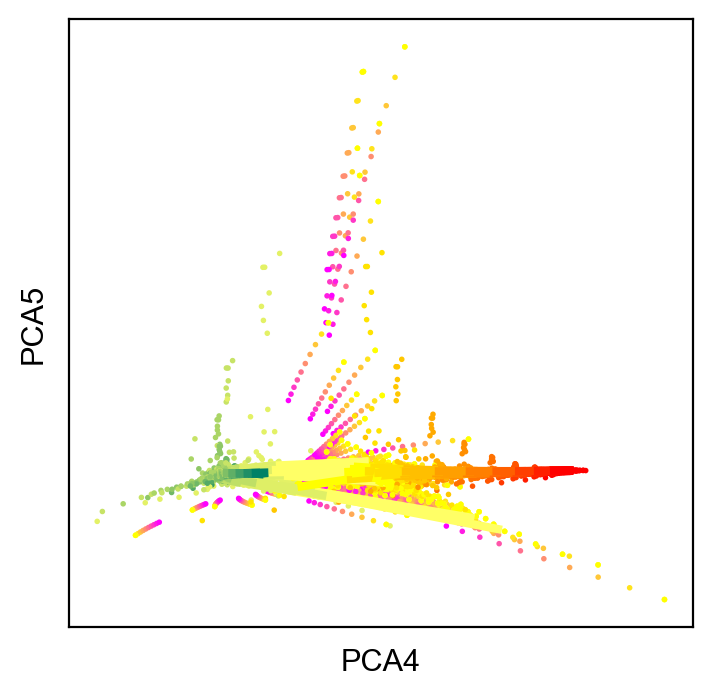

In [442]:
plt.rcParams["figure.figsize"] = (4,4)
n_traj = len(all_traj_cat) // 10

pca_comp_1 = 4 # 0
pca_comp_2 = 5 # 4


selected_trajs_obs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_abex = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]
selected_trajs_belin = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=10)]

control_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "control"]
plt.scatter(control_trajs.obsm["X_pca"][:, pca_comp_1], control_trajs.obsm["X_pca"][:, pca_comp_2], c=control_trajs.obs["time"], s=1, cmap=plt.get_cmap("spring_r"))

abex_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Abexinostat"]
plt.scatter(abex_trajs.obsm["X_pca"][:, pca_comp_1], abex_trajs.obsm["X_pca"][:, pca_comp_2], c=abex_trajs.obs["time"], s=1, cmap=plt.get_cmap("summer_r"))

belin_trajs = all_traj_adata[all_traj_adata.obs["perturbation"] == "Belinostat"]
plt.scatter(belin_trajs.obsm["X_pca"][:, pca_comp_1], belin_trajs.obsm["X_pca"][:, pca_comp_2], c=belin_trajs.obs["time"], s=1, cmap=plt.get_cmap("autumn_r"))


plt.xlabel("PCA4")
plt.ylabel("PCA5")
plt.xticks([])
plt.yticks([])

cmap = plt.get_cmap("spring_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_obs:
    for i in range(n_colors):
        plt.plot(control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], control_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = plt.get_cmap("summer_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_abex:
    for i in range(n_colors):
        plt.plot(abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], abex_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

cmap = plt.get_cmap("autumn_r")
n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs_belin:
    for i in range(n_colors):
        plt.plot(belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_1], belin_trajs.obsm["X_pca"][traj[i:i+2], pca_comp_2], c=colors[i], linewidth=3)

plt.show()

## Baseline with no Flow Matching augmentation

In [62]:
mycellpop_baseline = SciplexGRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)
mycellpop_baseline = mycellpop_baseline.to(device)

In [63]:
# Load trained weights
trained_state_dict_baseline = torch.load(os.path.join(get_project_root(), "logs", "trained_mycellpop_mar_07_1.pt"))

In [64]:
mycellpop_baseline["gene"].alpha.data = trained_state_dict_baseline["alpha"]
mycellpop_baseline["gene"].bias.data = trained_state_dict_baseline["bias"]
mycellpop_baseline["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict_baseline["simple_conv_weights"]

In [65]:
path_length = 2
all_traj_baseline = []

with torch.no_grad():

    for i in tqdm(range(start_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(start_adata.X[i*batch_size: (i + 1)*batch_size, :, None]).to(device)
        
        mycellpop_baseline.set_visible_state(gene_expr)
        
        traj = simulate_deterministic_trajectory(mycellpop_baseline, torch.linspace(0, path_length-1, 10))
        traj = traj[:, :, :mycellpop_baseline.n_genes, 0]

        all_traj_baseline.append(traj)
        
#         if i == 4:
#             break

100%|██████████| 10/10 [01:35<00:00,  9.57s/it]


In [66]:
all_traj_baseline_cat = torch.cat(all_traj_baseline)

In [67]:
obs_times = torch.cat([torch.linspace(0, path_length-1, 10)[None]]*len(all_traj_baseline_cat)).reshape(-1).numpy()

In [68]:
traj_baseline_adata = ad.AnnData(all_traj_baseline_cat.reshape(-1, 4000).cpu().numpy(), obs=obs_times)

In [69]:
traj_baseline_adata.obs = traj_baseline_adata.obs.rename(columns={0: "time"})

In [70]:
sc.tl.pca(traj_baseline_adata)
sc.pp.neighbors(traj_baseline_adata, n_neighbors=50)

## Earth Mover distances

In [71]:
obs_bis_adata = obs_adata.copy()

In [72]:
obs_bis_adata.var.reset_index(inplace=True, drop=True)
traj_adata.var.reset_index(inplace=True, drop=True)
traj_baseline_adata.var.reset_index(inplace=True, drop=True)

In [73]:
obs_bis_adata.obs["type"] = "ground_truth"
traj_adata.obs["type"] = "generated"
traj_baseline_adata.obs["type"] = "generated (baseline)"

In [74]:
import anndata as ad
both_adata = ad.concat([obs_bis_adata, traj_adata, traj_baseline_adata])

In [75]:
sc.tl.pca(both_adata, svd_solver="arpack", n_comps=50)
sc.pp.neighbors(both_adata, n_neighbors=5, n_pcs=50)
sc.tl.umap(both_adata, maxiter=600)

In [76]:
target_dist = both_adata[both_adata.obs["time"] == 72.]

In [77]:
all_res_df = pd.DataFrame(columns=["time", "emd"])

for seed in range(5):

    n_traj = len(both_adata[both_adata.obs["type"] == "generated"]) // 10
    first_point_traj = [10*i for i in np.random.randint(n_traj, size=len(target_dist))]

    X_targ = target_dist.obsm["X_pca"]

    for j in range(10):
        j_time_point_traj = [j + 10*i for i in np.random.randint(n_traj, size=len(target_dist))]
        X_j = both_adata[both_adata.obs["type"] == "generated"][j_time_point_traj].obsm["X_pca"]
        emd = compute_emd(X_targ, X_j)

        res_df = pd.DataFrame([[48*j/9, emd]], columns=["time", "emd"])
        all_res_df = pd.concat([all_res_df, res_df])

In [78]:
all_res_baseline_df = pd.DataFrame(columns=["time", "emd"])

for seed in range(5):

    n_traj = len(both_adata[both_adata.obs["type"] == "generated (baseline)"]) // 10
    first_point_traj = [10*i for i in np.random.randint(n_traj, size=len(target_dist))]

    X_targ = target_dist.obsm["X_pca"]

    for j in range(10):
        j_time_point_traj = [j + 10*i for i in np.random.randint(n_traj, size=len(target_dist))]
        X_j = both_adata[both_adata.obs["type"] == "generated (baseline)"][j_time_point_traj].obsm["X_pca"]
        emd = compute_emd(X_targ, X_j)

        res_df = pd.DataFrame([[48*j/9, emd]], columns=["time", "emd"])
        all_res_baseline_df = pd.concat([all_res_df, res_df])

In [79]:
initial_dist = both_adata[both_adata.obs["time"] == 24.]

emd_lower_bound = []

for j in range(5):
    rand_half = np.random.randint(len(initial_dist), size=len(initial_dist) // 2)
    X_half_1  = initial_dist[rand_half].obsm["X_pca"]
    X_half_2  = initial_dist[[i for i in range(len(initial_dist)) if i not in rand_half]].obsm["X_pca"]

    emd_lower_bound.append(compute_emd(X_half_1, X_half_2))

print(emd_lower_bound)

[0.7280826491397457, 0.7144179359973094, 0.6997761664001677, 0.7765872191358684, 0.7480363235342707]


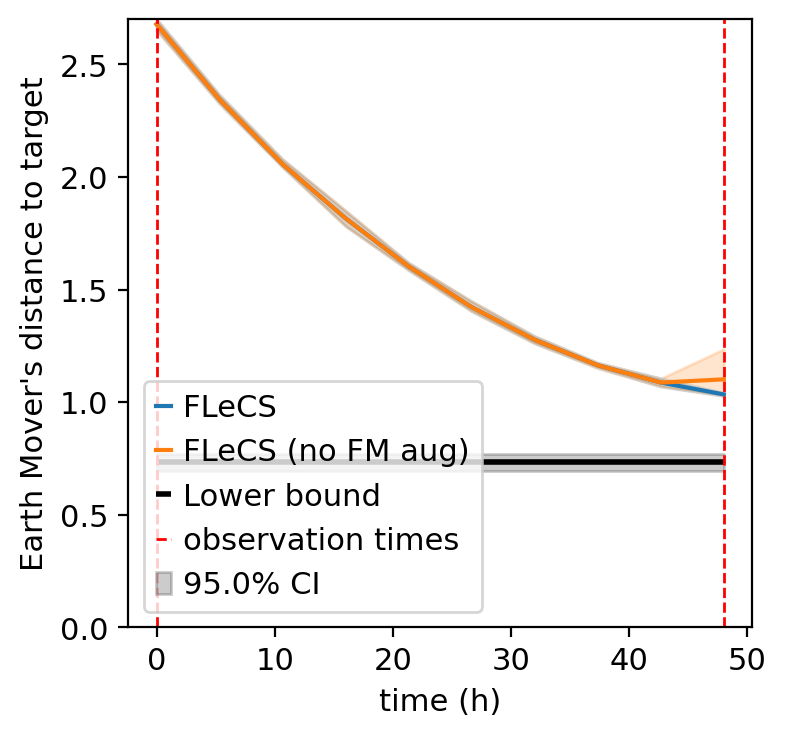

In [80]:
plt.rcParams["figure.figsize"] = (4,4)
sns.lineplot(all_res_df, x="time", y="emd", label="FLeCS")
sns.lineplot(all_res_baseline_df, x="time", y="emd", label="FLeCS (no FM aug)")
plt.xlabel("time (h)")
plt.ylabel("Earth Mover's distance to target")

# Calculate mean and confidence interval for lower bound
mean_y = np.mean(emd_lower_bound)
confidence_level = 0.95
degrees_freedom = len(emd_lower_bound) - 1
confidence_interval = scipy.stats.t.interval(confidence_level, degrees_freedom, loc=mean_y, scale=scipy.stats.sem(emd_lower_bound))
lower_bound, upper_bound = confidence_interval

# Define X-axis range
x_start, x_end = 0, 48

# Plot horizontal line with confidence interval
plt.hlines(mean_y, x_start, x_end, color='black', linewidth=2, label='Lower bound')
plt.vlines(48, 0., 2.8, color='red', linewidth=1, label='observation times', linestyle='--')
plt.vlines(0, 0., 2.8, color='red', linewidth=1, linestyle='--')
plt.fill_betweenx([lower_bound, upper_bound], x_start, x_end, color='black', alpha=0.2, label=f"{confidence_level * 100}% CI")

plt.ylim([0, 2.7])

plt.legend()
plt.show()

## Interventional model

In [81]:
start_adata.shape

(590, 4000)

In [82]:
batch_size = start_adata.shape[0] // 10
mycellpop.change_batch_size(batch_size)

In [83]:
mycellpop.state.shape

torch.Size([59, 4000, 1])

In [89]:
def compute_traj(path_length):
    all_traj_int = []
    
    with torch.no_grad():
        for i in tqdm(range(1)):
            gene_expr = torch.Tensor(start_adata.X[i*batch_size: (i + 1)*batch_size, :, None]).to(device)
            
            mycellpop.set_visible_state(gene_expr)
            
            traj = simulate_deterministic_trajectory(mycellpop, torch.linspace(0, 1, path_length).to(device))
            traj = traj[:, :, :mycellpop.n_genes, 0]

            all_traj_int.append(traj)
    
    all_traj_int_cat = torch.cat(all_traj_int)
    obs_times = torch.cat([torch.linspace(0, 1, path_length)[None]]*len(all_traj_int_cat)).reshape(-1).numpy()
    traj_int_adata = ad.AnnData(all_traj_int_cat.reshape(-1, 4000).cpu().numpy(), obs=obs_times)
    traj_int_adata.obs = traj_int_adata.obs.rename(columns={0: "time"})

    return traj_int_adata


In [91]:
sc.read_h5ad(os.path.join(get_project_root(), "figure5/logs/scgen_in_sample_preds.h5ad")).obs["perturbation"]

0        Roxadustat (FG-4592)
24       Roxadustat (FG-4592)
26       Roxadustat (FG-4592)
35       Roxadustat (FG-4592)
41       Roxadustat (FG-4592)
                 ...         
25464             Pirarubicin
25505             Pirarubicin
25518             Pirarubicin
25521             Pirarubicin
25568             Pirarubicin
Name: perturbation, Length: 40050, dtype: category
Categories (30, object): ['AMG-900', 'Abexinostat (PCI-24781)', 'Alisertib (MLN8237)', 'Barasertib (AZD1152-HQPA)', ..., 'Thiotepa', 'Trichostatin A (TSA)', 'Tucidinostat (Chidamide)', 'ZM 447439']

In [101]:
def plot_emd_for_pert(pert_name, perts_with_fp_dict, show_scgen=True):
    path_length = 10

    mycellpop.intervene(torch.tensor(perts_with_fp_dict[pert_name])[None, :].to(device))
    traj_int_adata = compute_traj(path_length)
    mycellpop.intervene(None)
    traj_obs_adata = compute_traj(path_length)

    pert_adata = adata[adata.obs["perturbation"] == pert_name]
    obs_bis_adata = obs_adata.copy()

    scgen_out_sample_preds_adata = sc.read_h5ad(os.path.join(get_project_root(), "figure5/logs/scgen_in_sample_preds.h5ad"))
    scgen_out_sample_preds_adata = scgen_out_sample_preds_adata[scgen_out_sample_preds_adata.obs["perturbation"] == pert_name].copy()

    obs_bis_adata.obs["type"] = "ground_truth"
    traj_int_adata.obs["type"] = "generated (interv)"
    traj_obs_adata.obs["type"] = "generated (obs)"
    pert_adata.obs["type"] = "perturbed"
    scgen_out_sample_preds_adata.obs["type"] = "scgen"

    obs_bis_adata.var.reset_index(inplace=True)
    traj_int_adata.var.reset_index(inplace=True)
    traj_obs_adata.var.reset_index(inplace=True)
    pert_adata.var.reset_index(inplace=True)
    scgen_out_sample_preds_adata.var.reset_index(inplace=True)

    combined_adata = ad.concat([obs_bis_adata, traj_int_adata, traj_obs_adata, pert_adata, scgen_out_sample_preds_adata])

    sc.tl.pca(combined_adata, svd_solver="arpack", n_comps=50)

    all_res_df = pd.DataFrame(columns=["time", "emd"])

    for seed in range(10):

        n_traj = len(combined_adata[combined_adata.obs["type"] == "generated (interv)"]) // path_length
        X_targ = combined_adata[combined_adata.obs["type"] == "perturbed"].obsm["X_pca"]

        for j in range(path_length):
            j_time_point_traj = [j + path_length*i for i in np.random.randint(n_traj, size=len(pert_adata))]
            X_j = combined_adata[combined_adata.obs["type"] == "generated (interv)"][j_time_point_traj].obsm["X_pca"]
            X_j_obs = combined_adata[combined_adata.obs["type"] == "generated (obs)"][j_time_point_traj].obsm["X_pca"]
            
            emd = compute_emd(X_targ, X_j)
            res_df = pd.DataFrame([[(48/(path_length-1))*j, emd, "intervened"]], columns=["time", "emd", "mode"])

            emd = compute_emd(X_targ, X_j_obs)
            res_df_obs = pd.DataFrame([[(48/(path_length-1))*j, emd, "observational"]], columns=["time", "emd", "mode"])

            all_res_df = pd.concat([all_res_df, res_df, res_df_obs])

    emd_lower_bound = []

    for j in range(5):
        rand_half = np.random.randint(len(pert_adata), size=len(pert_adata) // 2)
        X_half_1  = combined_adata[combined_adata.obs["type"] == "perturbed"][rand_half].obsm["X_pca"]
        X_half_2  = combined_adata[combined_adata.obs["type"] == "perturbed"][[i 
                                                                               for i in range(len(pert_adata)) 
                                                                               if i not in rand_half]].obsm["X_pca"]

        emd_lower_bound.append(compute_emd(X_half_1, X_half_2))

    # Calculate mean and confidence interval for lower bound
    mean_y = np.mean(emd_lower_bound)
    confidence_level = 0.95
    degrees_freedom = len(emd_lower_bound) - 1
    confidence_interval = scipy.stats.t.interval(confidence_level, degrees_freedom, loc=mean_y, scale=scipy.stats.sem(emd_lower_bound))
    lower_bound, upper_bound = confidence_interval

    plt.rcParams["figure.figsize"] = (4,4)
    sns.lineplot(all_res_df, x="time", y="emd", hue="mode")
    plt.title(pert_name)

    if show_scgen:
        X_targ = combined_adata[combined_adata.obs["type"] == "perturbed"].obsm["X_pca"]
        X_scgen = combined_adata[combined_adata.obs["type"] == "scgen"].obsm["X_pca"]
        scgen_perf = compute_emd(X_scgen, X_targ)
        plt.hlines(scgen_perf, 0., 48., color='red', linewidth=2, label='scGen')

    plt.hlines(mean_y, 0., 48., color='black', linewidth=2, label='Lower bound')
    plt.fill_betweenx([lower_bound, upper_bound], 0., 48., color='black', alpha=0.2, label=f"{confidence_level * 100}% CI")

    plt.legend()
    plt.xlabel("time (h)")
    plt.ylabel("Earth Mover's distance to target")
    plt.show()

In [93]:
pert_accuracies_dict = np.load(os.path.join(get_project_root(), 
                                            "datasets/Sciplex3/processed/pert_accuracies_dict.npy"),
                              allow_pickle=True).item()

In [94]:
[k for k, v in pert_accuracies_dict.items() if v > 0.9]

['Abexinostat (PCI-24781)',
 'Cyclocytidine HCl',
 'Fluorouracil (5-Fluoracil, 5-FU)',
 'Trichostatin A (TSA)',
 'AR-42',
 'Pracinostat (SB939)',
 'Givinostat (ITF2357)',
 'Quisinostat (JNJ-26481585) 2HCl']

In [95]:
clean_perts_train = set([k for k, v in pert_accuracies_dict.items() if v > 0.85]).intersection(train_perts_with_fp_dict.keys())
clean_perts_valid = set([k for k, v in pert_accuracies_dict.items() if v > 0.8]).intersection(valid_perts_with_fp_dict.keys())

In [96]:
clean_perts_train

{'Abexinostat (PCI-24781)',
 'Belinostat (PXD101)',
 'Cerdulatinib (PRT062070, PRT2070)',
 'Entinostat (MS-275)',
 'Fluorouracil (5-Fluoracil, 5-FU)',
 'Panobinostat (LBH589)',
 'Trichostatin A (TSA)',
 'Tucidinostat (Chidamide)'}

In [97]:
clean_perts_valid

{'Carmofur',
 'Gandotinib (LY2784544)',
 'Resminostat',
 'Trametinib (GSK1120212)',
 'Triamcinolone Acetonide'}

100%|██████████| 1/1 [00:07<00:00,  7.26s/it]


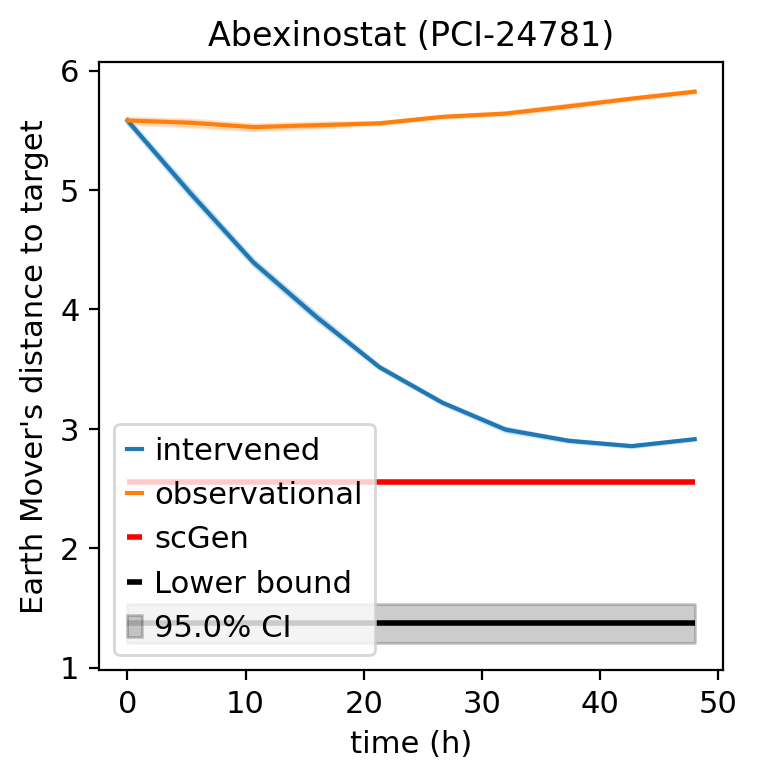

In [98]:
plot_emd_for_pert('Abexinostat (PCI-24781)', train_perts_with_fp_dict)

Panobinostat (LBH589)


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


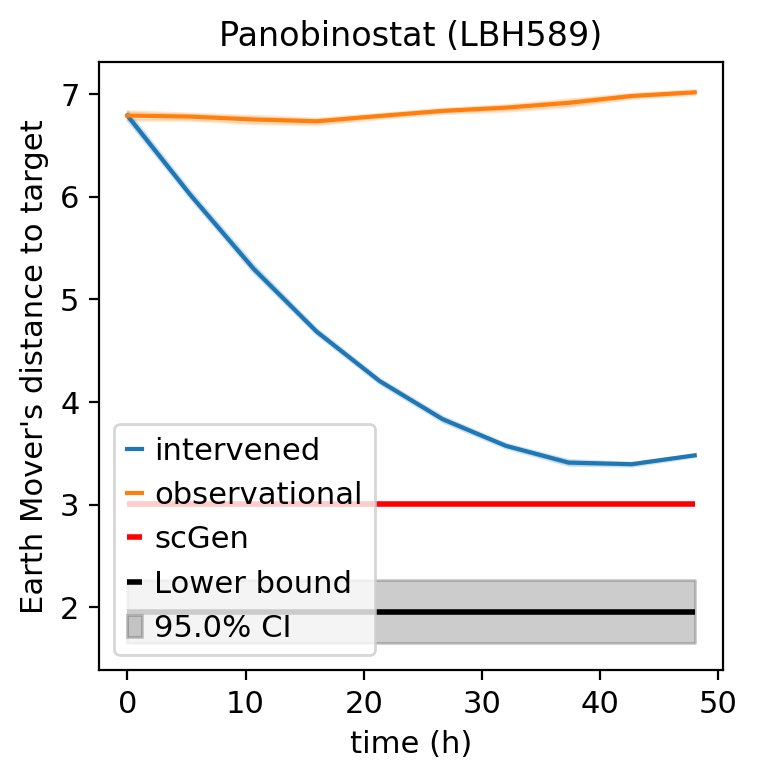

Trichostatin A (TSA)


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


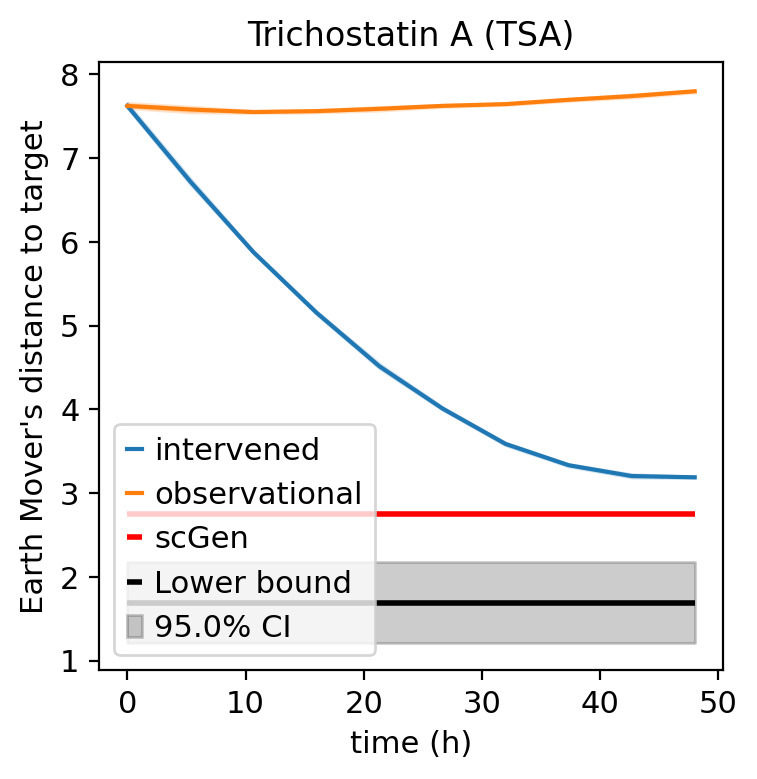

Belinostat (PXD101)


100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


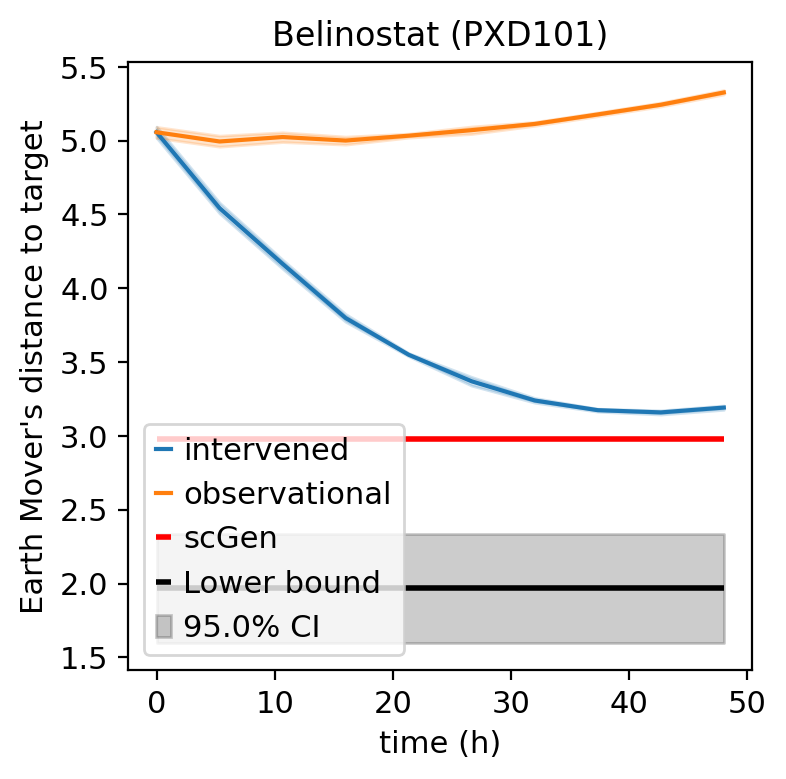

Entinostat (MS-275)


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


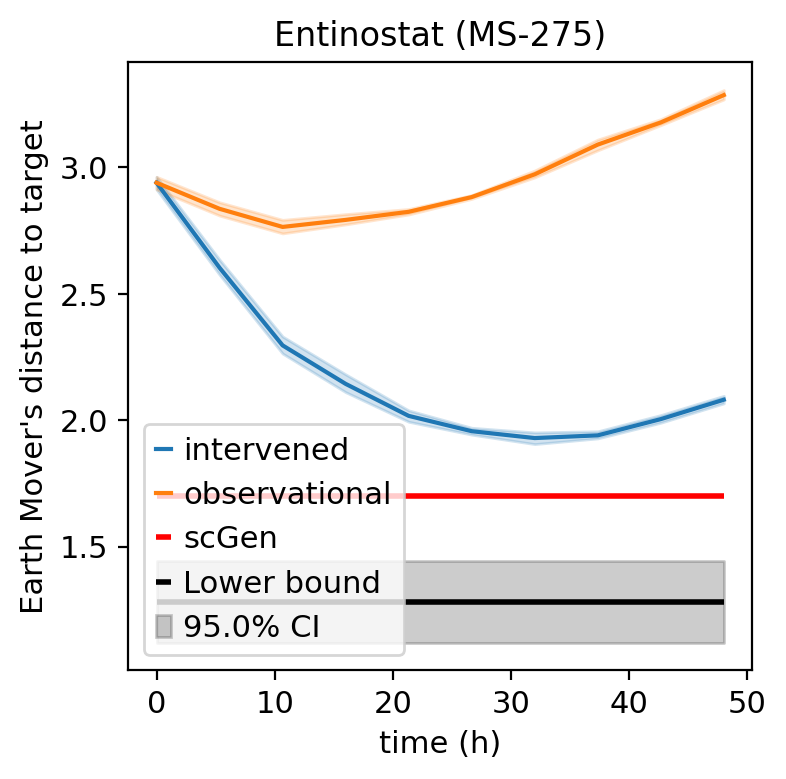

Abexinostat (PCI-24781)


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


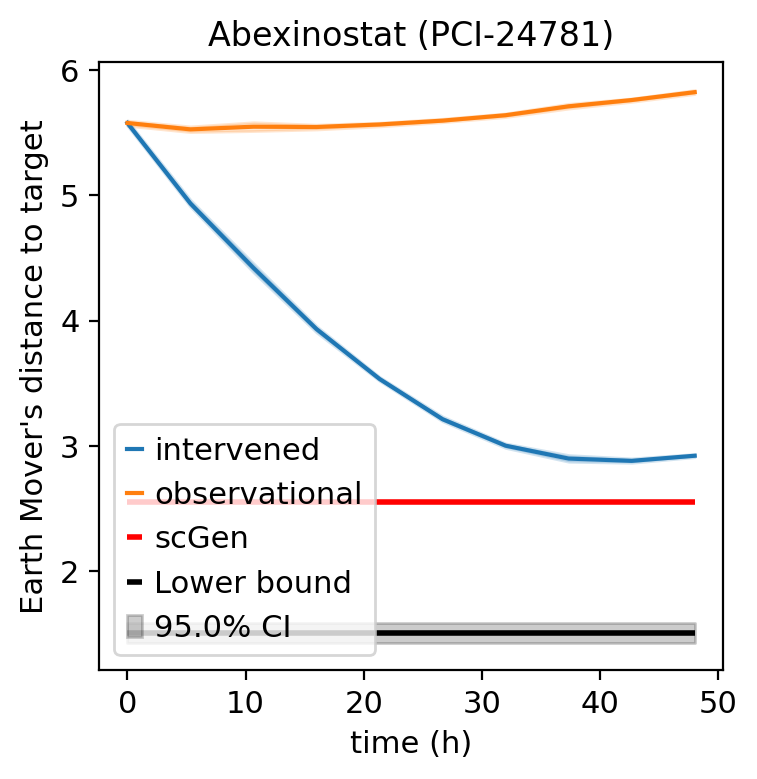

Tucidinostat (Chidamide)


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


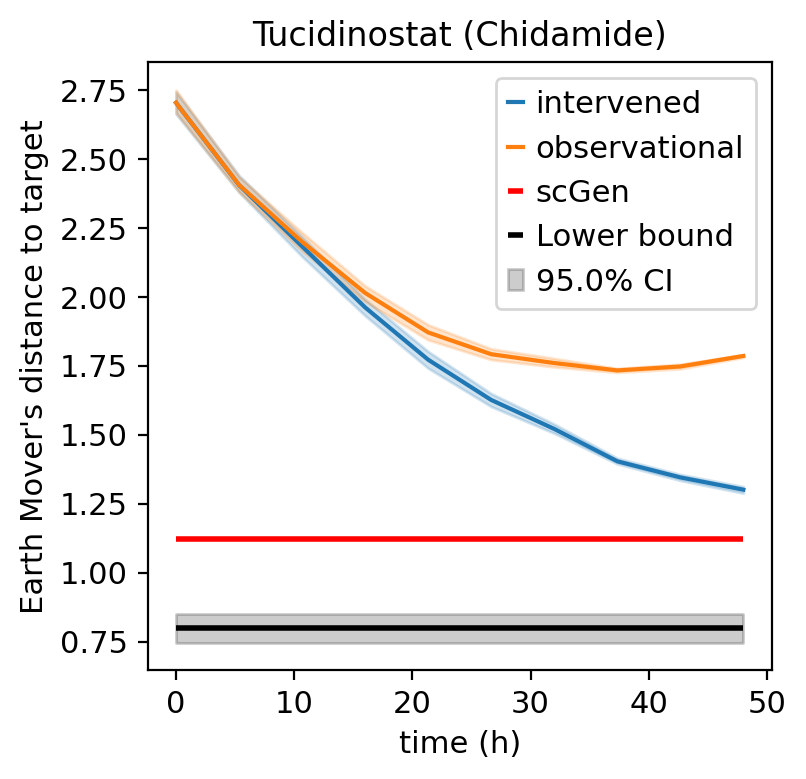

Cerdulatinib (PRT062070, PRT2070)


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


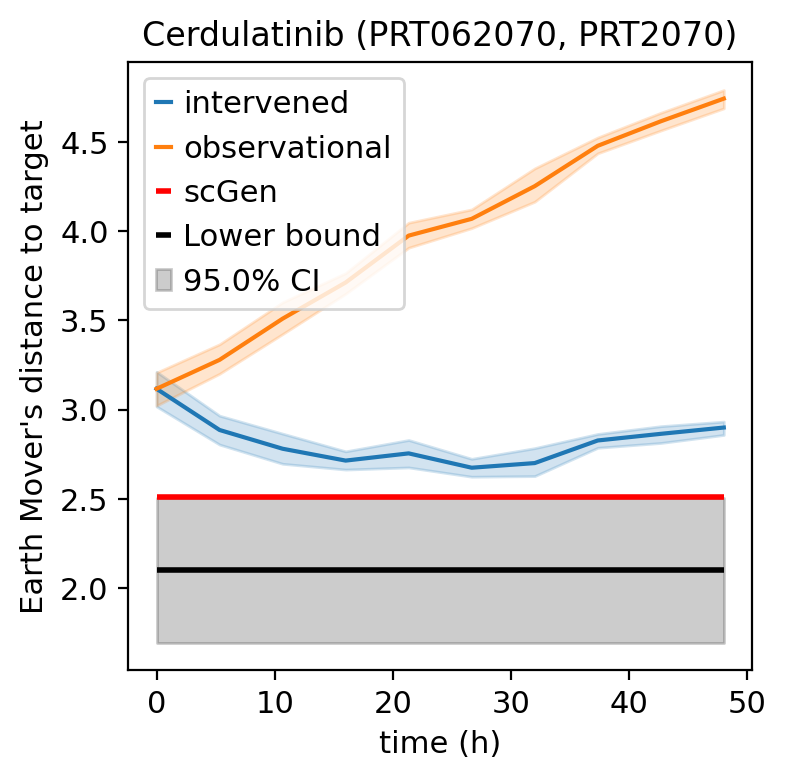

Fluorouracil (5-Fluoracil, 5-FU)


100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


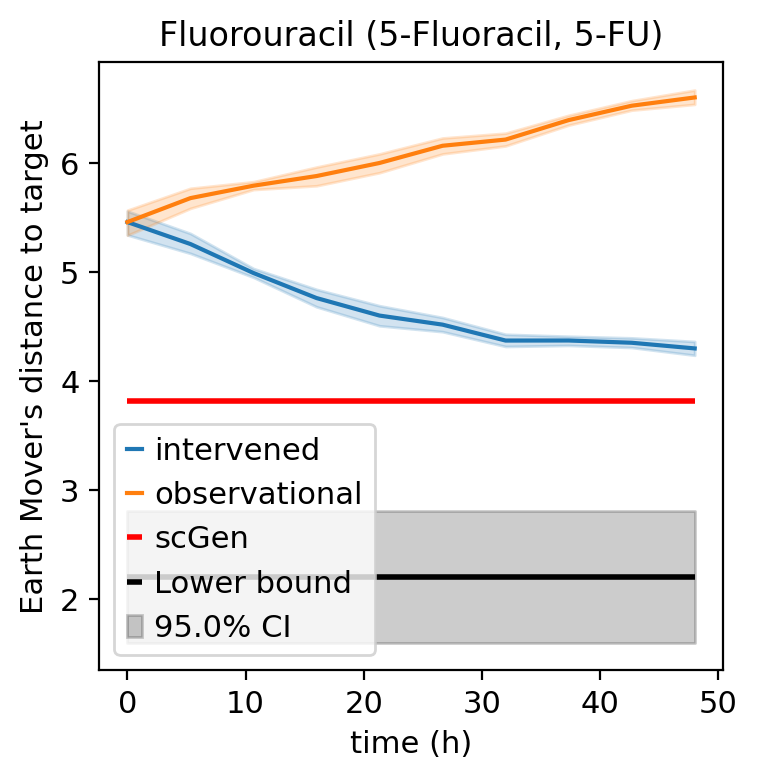

In [99]:
for pert_name in clean_perts_train:
    print(pert_name)
    plot_emd_for_pert(pert_name, train_perts_with_fp_dict)

Triamcinolone Acetonide


100%|██████████| 1/1 [00:07<00:00,  7.26s/it]


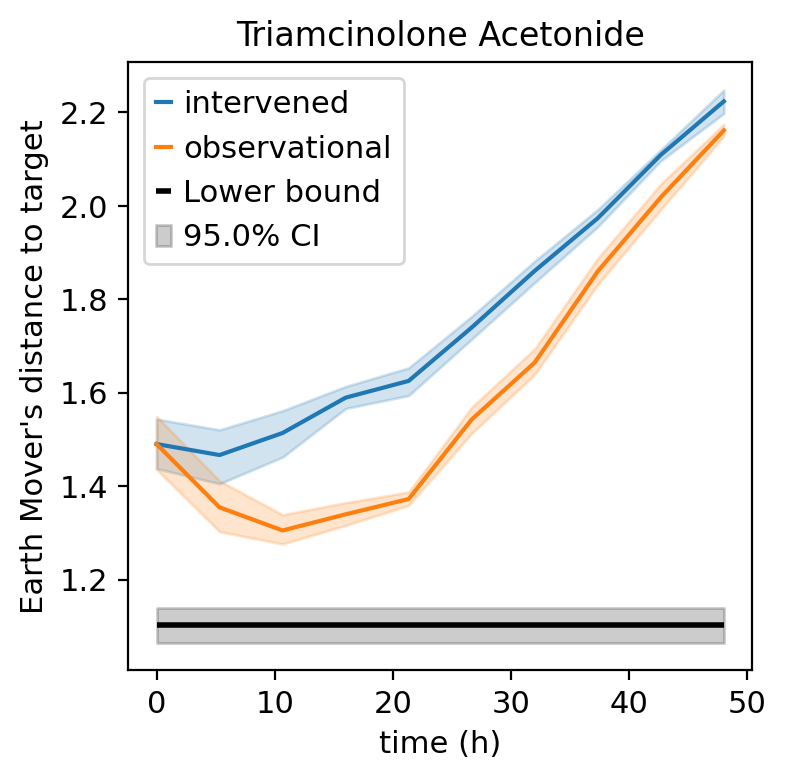

Trametinib (GSK1120212)


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


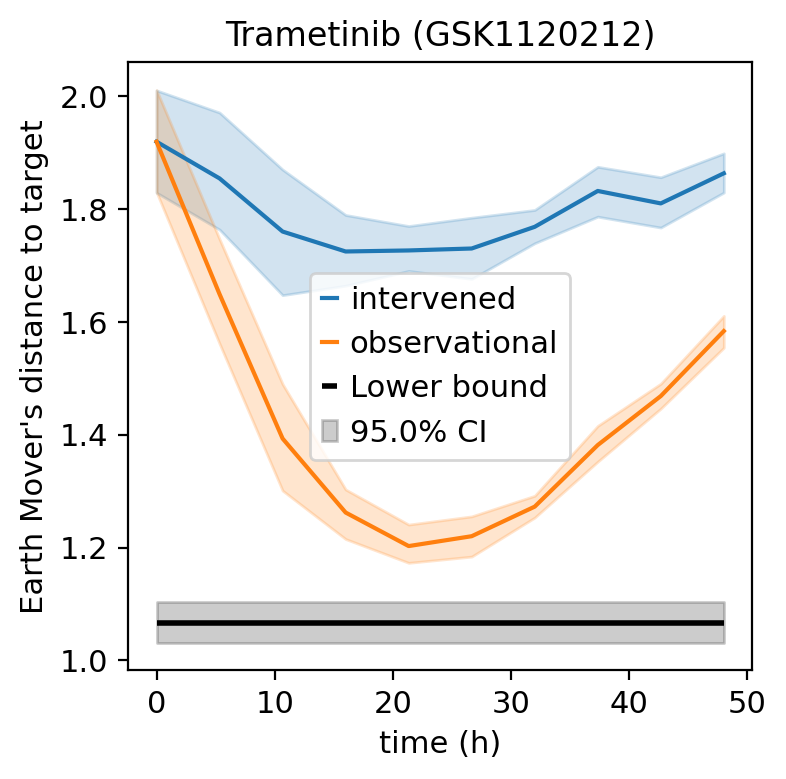

Resminostat


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


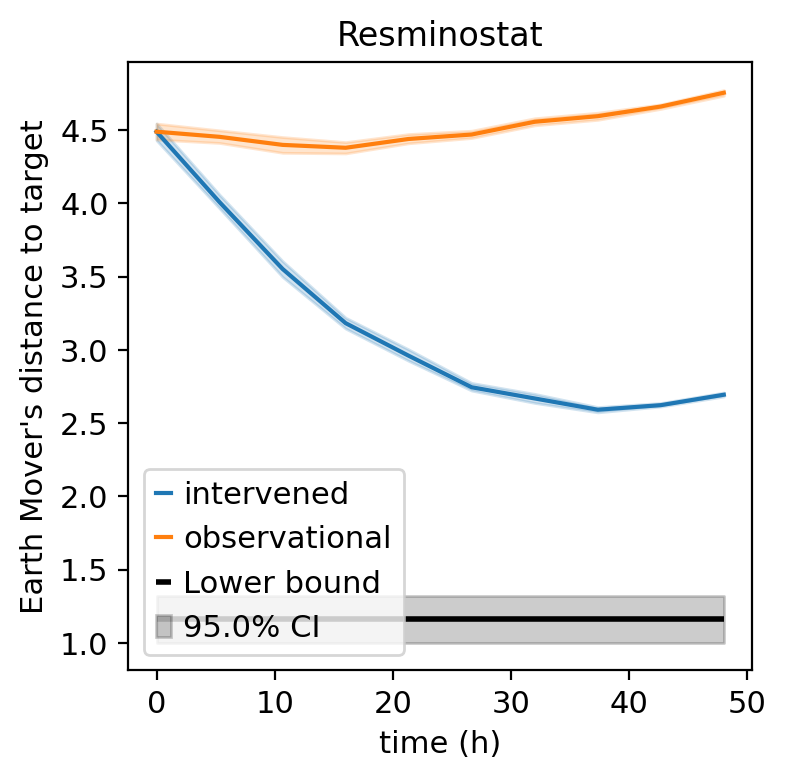

Gandotinib (LY2784544)


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


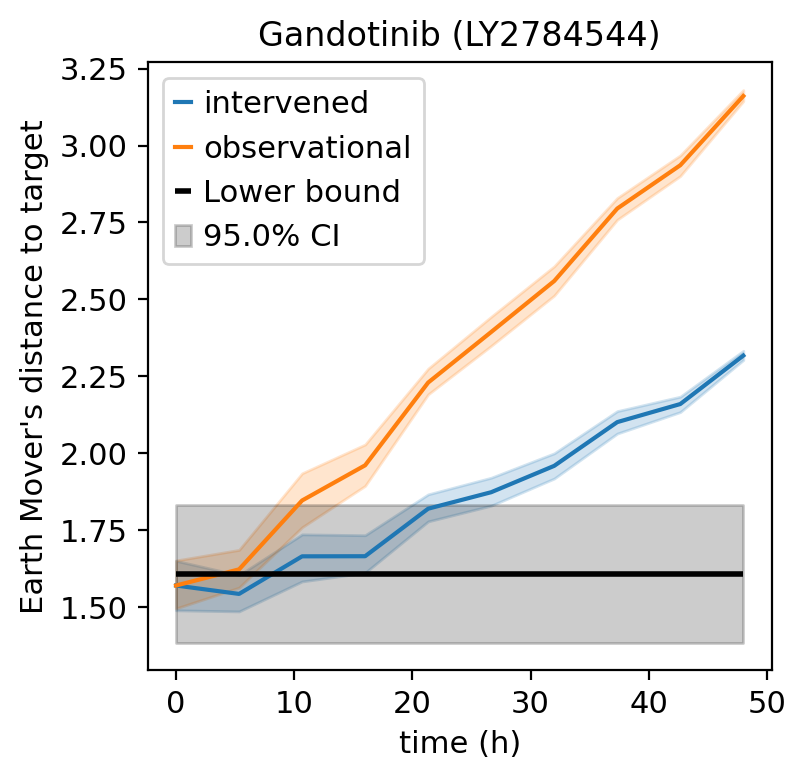

Carmofur


100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


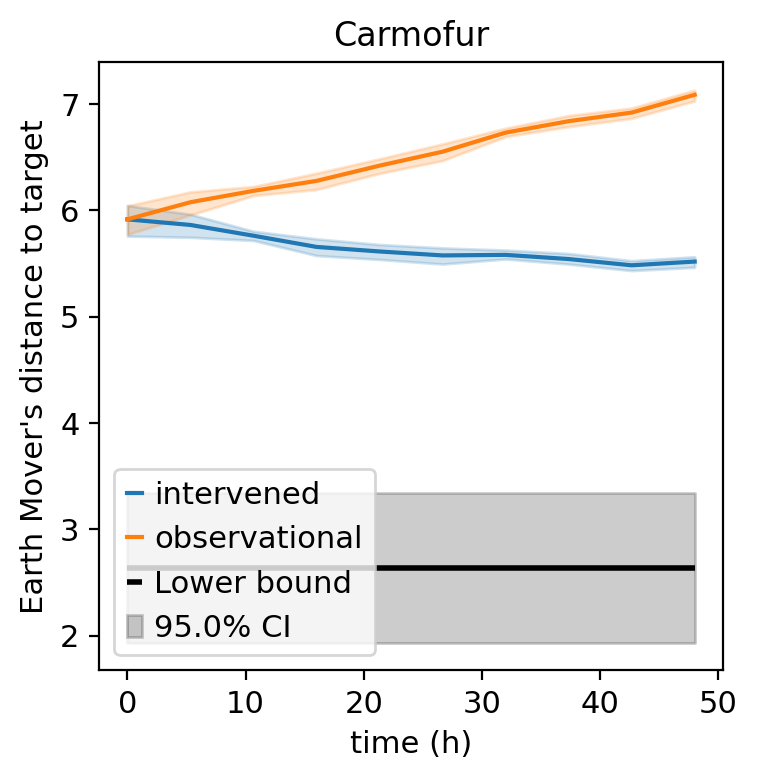

In [102]:
for pert_name in clean_perts_valid:
    print(pert_name)
    plot_emd_for_pert(pert_name, valid_perts_with_fp_dict, show_scgen=False)